In [1]:
import pandas as pd
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Core model + dataset (keep as-is)
# -------- Sliding-window dataset --------

class SlidingWindowDataset(Dataset):
    """
    Turn a time series (T, N) into input/target windows for forecasting.

    series: np.ndarray, shape (T,) or (T, N)
    input_len: length of history window
    pred_len:  length of prediction horizon
    """
    def __init__(self, series, input_len, pred_len, stride=1):
        if series.ndim == 1:
            series = series[:, None]  # (T,) -> (T,1)
        T, N = series.shape

        X_list, y_list = [], []
        for start in range(0, T - input_len - pred_len + 1, stride):
            end = start + input_len
            target_end = end + pred_len
            X_list.append(series[start:end])        # (input_len, N)
            y_list.append(series[end:target_end])   # (pred_len, N)

        self.X = torch.from_numpy(np.stack(X_list)).float()  # (B, L, N)
        self.y = torch.from_numpy(np.stack(y_list)).float()  # (B, H, N)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------- Positional encodings --------

class SinusoidalPositionalEncoding(nn.Module):
    """Standard Transformer sinusoidal positional encoding."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]


class LearnablePositionalEncoding(nn.Module):
    """Learnable positional embeddings (one vector per index)."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pos_embed = nn.Embedding(max_len, d_model)

    def forward(self, x):
        b, seq_len, _ = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(b, -1)
        return x + self.pos_embed(positions)


# -------- Time-series Transformer --------

class TimeSeriesTransformer(nn.Module):
    """
    Simple encoder-only Transformer for time-series forecasting.

    - Supports sinusoidal or learnable positional encoding.
    - Predicts 'pred_len' future steps for each input series.
    """
    def __init__(
        self,
        input_dim=1,
        d_model=64,
        n_heads=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        pred_len=1,
        pos_encoding_type="sin",  # "sin" or "learned"
        max_len=500,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.pred_len = pred_len

        self.input_proj = nn.Linear(input_dim, d_model)

        if pos_encoding_type == "sin":
            self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_len)
        elif pos_encoding_type == "learned":
            self.pos_encoding = LearnablePositionalEncoding(d_model, max_len)
        else:
            self.pos_encoding = None  # no PE (for ablation)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # (B, L, D)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, pred_len * input_dim)
        self.attn_weights = []  # Store attention weights


        def custom_forward(module, src, src_mask=None, src_key_padding_mask=None):
            attn_output, attn_weight = module.self_attn(
                src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask, need_weights=True, average_attn_weights=False
            )
            module.attn_weight = attn_weight  # save for extraction
            src = module.norm1(src + module.dropout1(attn_output))
            src = module.norm2(src + module.dropout2(module.linear2(module.dropout(module.activation(module.linear1(src))))))
            return src


        for layer in self.encoder.layers:
            def layer_forward(src, *args, **kwargs):
                return custom_forward(layer, src, src_mask=kwargs.get("src_mask"), src_key_padding_mask=kwargs.get("src_key_padding_mask"))
            layer.forward = layer_forward


    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        returns: (batch, pred_len, input_dim)
        """
        h = self.input_proj(x)  # (B, L, d_model)

        if self.pos_encoding is not None:
            h = self.pos_encoding(h)

        h = self.encoder(h)     # (B, L, d_model)
        h_last = h[:, -1, :]    # (B, d_model)

        out = self.fc_out(h_last)                     # (B, pred_len * input_dim)
        out = out.view(-1, self.pred_len, self.input_dim)  # (B, pred_len, input_dim)
        return out



def plot_attention_map(attn, input_len, title="", head=0):
    """
    attn: tensor of shape (num_heads, B, T_q, T_k)
    """
    head_attn = attn[head, 0]  # choose head 0, batch 0
    plt.figure(figsize=(8, 6))
    sns.heatmap(head_attn[:, :input_len], cmap="viridis")
    plt.title(title)
    plt.xlabel("Key Time Step")
    plt.ylabel("Query Time Step")
    plt.tight_layout()
    plt.show()



In [2]:
# 1. Single training wrapper (reuse everywhere)
def train_transformer_on_series(
    series,
    input_len=64,
    pred_len=1,
    batch_size=32,
    n_epochs=10,
    lr=1e-3,
    pos_encoding_type="sin",
    device=None,
):
    """
    Train a TimeSeriesTransformer on one time series.

    Returns
    -------
    model : nn.Module
    history : dict with keys 'train_loss', 'val_loss'
    test_loss : float (MSE on held-out test set)
    splits : (train_set, val_set, test_set)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure shape (T, N)
    if isinstance(series, np.ndarray) and series.ndim == 1:
        series = series[:, None]
    elif torch.is_tensor(series) and series.ndim == 1:
        series = series.unsqueeze(-1).cpu().numpy()

    dataset = SlidingWindowDataset(series, input_len, pred_len)
    n_total = len(dataset)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    train_set, val_set, test_set = torch.utils.data.random_split(
        dataset,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(42),
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size)
    test_loader  = DataLoader(test_set,  batch_size=batch_size)

    model = TimeSeriesTransformer(
        input_dim=dataset.X.shape[-1],
        d_model=32,
        n_heads=4,
        num_layers=1,
        dim_feedforward=64,
        dropout=0.1,
        pred_len=pred_len,
        pos_encoding_type=pos_encoding_type,
        max_len=input_len,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(n_epochs):
        # --- train ---
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # --- validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch+1}/{n_epochs} "
            f"| train={train_loss:.4f} | val={val_loss:.4f}"
        )

    # --- test ---
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test MSE: {test_loss:.4f}")

    return model, history, test_loss, (train_set, val_set, test_set)


In [3]:
import numpy as np

# -------------------------------
# (A) Heavy-Tailed AR(1) Process
# -------------------------------

def simulate_heavy_t_ar1(T, N=1, phi=0.5, df=3.0, burn_in=200, seed=None):
    """
    Heavy-tailed AR(1): X_t = phi * X_{t-1} + eps_t,
    where eps_t ~ Student-t(df).

    Parameters
    ----------
    T : int
        Length of series to return (after burn-in).
    N : int
        Number of independent series.
    phi : float
        AR(1) coefficient, |phi| < 1.
    df : float
        Degrees of freedom of Student-t innovations.
        df <= 2 → infinite variance.
    burn_in : int
        Extra steps to discard to reach stationarity.
    seed : int or None
        Random seed.

    Returns
    -------
    X : ndarray, shape (T, N)
        Simulated AR(1) series.
    """
    rng = np.random.default_rng(seed)
    total_T = T + burn_in

    eps = rng.standard_t(df, size=(total_T, N))

    X = np.zeros((total_T, N))
    # Start at zero (stationary mean) – burn-in handles transient anyway.
    for t in range(1, total_T):
        X[t] = phi * X[t - 1] + eps[t]

    # Drop burn-in
    return X[burn_in:]


# -------------------------------
# (B) GARCH(1,1) Volatility
# -------------------------------

def simulate_garch_11(T, omega=0.1, alpha=0.05, beta=0.9,
                      N=1, burn_in=200, seed=None):
    """
    GARCH(1,1): r_t = sigma_t * z_t,
    sigma_t^2 = omega + alpha * r_{t-1}^2 + beta * sigma_{t-1}^2,
    with z_t ~ N(0,1).

    Parameters
    ----------
    T : int
        Length of series to return (after burn-in).
    omega, alpha, beta : float
        GARCH(1,1) parameters. Typically alpha + beta < 1 for stationarity.
    N : int
        Number of independent series.
    burn_in : int
        Extra steps to discard.
    seed : int or None

    Returns
    -------
    r : ndarray, shape (T, N)
        Returns r_t.
    sigma : ndarray, shape (T, N)
        Conditional standard deviation sigma_t.
    """
    rng = np.random.default_rng(seed)
    total_T = T + burn_in

    z = rng.standard_normal(size=(total_T, N))
    r = np.zeros((total_T, N))
    sigma2 = np.zeros((total_T, N))

    # Initialize sigma^2 at unconditional variance if alpha + beta < 1
    if alpha + beta < 1:
        sigma2[0] = omega / (1 - alpha - beta)
    else:
        sigma2[0] = omega

    for t in range(1, total_T):
        r_sq_prev = r[t - 1] ** 2
        sigma2[t] = omega + alpha * r_sq_prev + beta * sigma2[t - 1]
        r[t] = np.sqrt(sigma2[t]) * z[t]

    return r[burn_in:], np.sqrt(sigma2[burn_in:])


# ------------------------------------------------
# (C) Regime-Switching Mean (2-state Markov chain)
# ------------------------------------------------

def simulate_regime_switching_mean(
    T,
    N=1,
    mu_A=0.0,
    mu_B=2.0,
    sigma_A=1.0,
    sigma_B=1.0,
    p_stay_A=0.95,
    p_stay_B=0.95,
    burn_in=100,
    seed=None,
):
    """
    Regime-switching process:
    X_t = mu_{s_t} + eps_t, eps_t ~ N(0, sigma_{s_t}^2),
    s_t ∈ {0 (A), 1 (B)} follows a 2-state Markov chain.

    Transition matrix:
        P = [[p_stay_A, 1 - p_stay_A],
             [1 - p_stay_B, p_stay_B]]

    Parameters
    ----------
    T : int
        Length (after burn-in).
    N : int
        Number of independent series.
    mu_A, mu_B : float
        Means of regimes A and B.
    sigma_A, sigma_B : float
        Std dev of regimes A and B.
    p_stay_A, p_stay_B : float
        Probability of staying in same regime for A and B.
    burn_in : int
    seed : int or None

    Returns
    -------
    X : ndarray, shape (T, N)
        Observations.
    S : ndarray, shape (T, N)
        Regime indicators (0 for A, 1 for B).
    """
    rng = np.random.default_rng(seed)
    total_T = T + burn_in

    # 0 = A, 1 = B
    S = np.zeros((total_T, N), dtype=int)
    # Initialize regimes (random)
    S[0] = rng.integers(0, 2, size=N)

    for t in range(1, total_T):
        prev = S[t - 1]
        # Draw uniform and decide whether to stay or switch
        u = rng.random(size=N)
        stay_A_mask = (prev == 0) & (u < p_stay_A)
        stay_B_mask = (prev == 1) & (u < p_stay_B)

        S[t] = prev  # default copy
        # Switch those not staying
        S[t][(prev == 0) & ~stay_A_mask] = 1
        S[t][(prev == 1) & ~stay_B_mask] = 0

    # Generate X given regimes
    X = np.zeros((total_T, N))
    for t in range(total_T):
        # Regime-dependent mean and sigma
        mu_t = np.where(S[t] == 0, mu_A, mu_B)
        sigma_t = np.where(S[t] == 0, sigma_A, sigma_B)
        X[t] = mu_t + sigma_t * rng.standard_normal(size=N)

    return X[burn_in:], S[burn_in:]


# -----------------------------------------------------
# (D) Long-Memory 1/f^β Noise via Spectral Synthesis
# -----------------------------------------------------

def simulate_1_over_f_noise(T, N=1, beta=0.8, seed=None):
    """
    Generate approximate 1/f^beta long-memory noise by shaping
    the power spectrum and inverse FFT.

    This is not an exact ARFIMA, but gives long-range dependence
    with power-law spectrum.

    Parameters
    ----------
    T : int
        Length of each series.
    N : int
        Number of series.
    beta : float
        Spectral slope: S(f) ∝ 1 / f^beta.
        beta in (0, 1) ~ weak to moderate long memory.
    seed : int or None

    Returns
    -------
    X : ndarray, shape (T, N)
        Long-memory time series (zero mean, unit-ish variance).
    """
    rng = np.random.default_rng(seed)

    # Frequencies for real FFT (rfft)
    freqs = np.fft.rfftfreq(T)
    # Avoid division by zero at f=0: set that amplitude separately
    amp = np.zeros_like(freqs)
    nonzero = freqs > 0
    amp[nonzero] = 1.0 / (freqs[nonzero] ** (beta / 2.0))

    X = np.zeros((T, N))
    for i in range(N):
        # Random complex spectrum with given amplitudes
        # real and imag parts ~ N(0, 1)
        re = rng.standard_normal(size=len(freqs))
        im = rng.standard_normal(size=len(freqs))
        # For real-valued signal, imaginary part at f=0 and Nyquist must be 0
        im[0] = 0.0
        spectrum = amp * (re + 1j * im)
        x = np.fft.irfft(spectrum, n=T)
        # Normalize to unit variance
        x = (x - x.mean()) / (x.std() + 1e-8)
        X[:, i] = x

    return X


# -----------------------------------------------------------
# (E) Seasonal Trend + Outliers (sinusoid + linear + spikes)
# -----------------------------------------------------------

def simulate_season_trend_outliers(
    T,
    N=1,
    season_period=24,
    A=1.0,
    trend_slope=0.001,
    noise_sigma=0.1,
    n_outliers=5,
    outlier_magnitude=5.0,
    seed=None,
):
    """
    Y_t = A * sin(2pi * t / S) + b * t + noise + occasional spikes.

    Parameters
    ----------
    T : int
        Length of series.
    N : int
        Number of series.
    season_period : int
        Season length S (e.g. 24 for daily cycle in hourly data).
    A : float
        Amplitude of sinusoidal season.
    trend_slope : float
        Linear trend slope b.
    noise_sigma : float
        Std dev of Gaussian noise eta_t.
    n_outliers : int
        Number of outlier timestamps per series.
    outlier_magnitude : float
        Size of outlier jump (±outlier_magnitude).
    seed : int or None

    Returns
    -------
    Y : ndarray, shape (T, N)
        Seasonal + trend + outlier time series.
    outlier_idx : list of lists
        For each series, the indices where outliers were added.
    """
    rng = np.random.default_rng(seed)

    t = np.arange(T)
    season = A * np.sin(2 * np.pi * t / season_period)
    trend = trend_slope * t

    Y = np.zeros((T, N))
    outlier_idx_all = []

    for i in range(N):
        noise = noise_sigma * rng.standard_normal(size=T)
        y = season + trend + noise

        # Choose outlier positions
        if n_outliers > 0:
            idx = rng.choice(T, size=n_outliers, replace=False)
            # Random sign for each outlier
            signs = rng.choice([-1.0, 1.0], size=n_outliers)
            y[idx] += signs * outlier_magnitude
        else:
            idx = np.array([], dtype=int)

        Y[:, i] = y
        outlier_idx_all.append(idx)

    return Y, outlier_idx_all






# --------------------------------------------------------------------
# (F) Gaussian Random Walk: Pure diffusion without mean reversion
# --------------------------------------------------------------------

def simulate_random_walk(T, N=1, drift=0.0, sigma=1.0, seed=None):
    rng = np.random.default_rng(seed)
    steps = drift + sigma * rng.standard_normal(size=(T, N))
    return np.cumsum(steps, axis=0)




# --------------------------------------------------------------------
# (G) Jump Diffusion Process: Discontinuous shocks + diffusion
# --------------------------------------------------------------------

def simulate_jump_diffusion(T, N=1, mu=0.0, sigma=1.0,
                             jump_lambda=0.05, jump_mu=0.0, jump_sigma=5.0, seed=None):
    rng = np.random.default_rng(seed)
    dt = 1
    normal_part = mu * dt + sigma * rng.standard_normal((T, N))
    jumps = rng.poisson(jump_lambda, size=(T, N)) * rng.normal(jump_mu, jump_sigma, size=(T, N))
    return np.cumsum(normal_part + jumps, axis=0)



# ---------------------------------------------------------------------
# (H) Multi-Frequency Seasonality: Sum of multiple sinusoids
# ---------------------------------------------------------------------

def simulate_multi_seasonality(T, N=1, freqs=(24, 100), amps=(1.0, 0.5), noise_sigma=0.1, seed=None):
    rng = np.random.default_rng(seed)
    t = np.arange(T).reshape(-1, 1)
    signal = sum(A * np.sin(2 * np.pi * t / P) for A, P in zip(amps, freqs))
    noise = noise_sigma * rng.standard_normal(size=(T, N))
    return signal + noise




# ---------------------------------------------------------------------
# (I) Structural Break (Trend): Sudden slope shift in mean
# ---------------------------------------------------------------------

def simulate_trend_breaks(T, N=1, slope1=0.01, slope2=-0.01, noise_sigma=0.1, breakpoint=0.5, seed=None):
    rng = np.random.default_rng(seed)
    t = np.arange(T).reshape(-1, 1)
    split = int(T * breakpoint)
    trend = np.piecewise(t,
                         [t < split, t >= split],
                         [lambda t: slope1 * t, lambda t: slope1 * split + slope2 * (t - split)])
    noise = noise_sigma * rng.standard_normal(size=(T, N))
    return trend + noise



In [4]:

def zscore(X, axis=0, eps=1e-8):
    mean = X.mean(axis=axis, keepdims=True)
    std = X.std(axis=axis, keepdims=True)
    return (X - mean) / (std + eps)

# Fix functions
def make_stationary_ar1(X): return zscore(X)
def make_stationary_garch(r): return zscore(r)
def make_stationary_regime(X): return zscore(np.diff(X, axis=0))
def make_stationary_long_memory(X): return zscore(X)
def make_stationary_season_trend(Y, season_period):
    dY = np.diff(Y, axis=0)
    if dY.shape[0] <= season_period:
        raise ValueError("Too short for season differencing")
    return zscore(dY[season_period:] - dY[:-season_period])
def make_stationary_random_walk(X): return zscore(np.diff(X, axis=0))
def make_stationary_jump_diffusion(X):
    X = np.clip(X, np.percentile(X, 1), np.percentile(X, 99))
    return zscore(X)
def make_stationary_multi_season(X, period1, period2):
    X1 = X[period1:] - X[:-period1]
    X2 = X1[period2:] - X1[:-period2]
    return zscore(X2)
def make_stationary_trend_break(X): return zscore(np.diff(X, axis=0))


def fix_distribution(family, series):
    if family == "Heavy-tailed AR(1)":
        return zscore(series)
    elif family == "GARCH(1,1)":
        return zscore(series)
    elif family == "Regime-switching":
        return zscore(np.diff(series, axis=0))
    elif family == "1/f noise":
        return zscore(series)
    elif family == "Season+Trend+Outliers":
        dY = np.diff(series, axis=0)
        if dY.shape[0] > 50:
            season_adj = dY[50:] - dY[:-50]
            return zscore(season_adj)
        else:
            return zscore(dY)
    elif family in ["Random Walk", "Jump Diffusion", "Trend Breaks"]:
        return zscore(np.diff(series, axis=0))
    elif family == "Multi-Seasonality":
        return zscore(series)
    else:
        raise ValueError(f"No fix defined for: {family}")


In [11]:

# Synthetic generation
T = 10_000
n_epochs = 30
X_A = simulate_heavy_t_ar1(T, N=1, seed=0)
r_B, _ = simulate_garch_11(T, N=1, seed=0)
X_C, _ = simulate_regime_switching_mean(T, N=1, seed=0)
X_D = simulate_1_over_f_noise(T, N=1, seed=0)
Y_E, _ = simulate_season_trend_outliers(T=2000, N=1, seed=0)
RW = simulate_random_walk(T, N=1, seed=0)
JD = simulate_jump_diffusion(T, N=1, seed=0)
MS = simulate_multi_seasonality(T, N=1, freqs=(50, 150), amps=(1.0, 0.8), seed=0)
TB = simulate_trend_breaks(T, N=1, seed=0)

# Raw dictionary
raw_dict = {
    "Heavy-tailed AR(1)": {"series": X_A[:, 0], "input_len": 64, "pos_encs": ["sin", "learned"]},
    "GARCH(1,1)":         {"series": r_B[:, 0], "input_len": 64, "pos_encs": ["sin"]},
    "Regime-switching":   {"series": X_C[:, 0], "input_len": 64, "pos_encs": ["sin"]},
    "1/f noise":          {"series": X_D[:, 0], "input_len": 128, "pos_encs": ["sin"]},
    "Season+Trend+Outliers": {"series": Y_E[:, 0], "input_len": 128, "pos_encs": ["sin"]},
    "Random Walk":        {"series": RW[:, 0], "input_len": 128, "pos_encs": ["sin"]},
    "Jump Diffusion":     {"series": JD[:, 0], "input_len": 128, "pos_encs": ["sin"]},
    "Multi-Seasonality":  {"series": MS[:, 0], "input_len": 128, "pos_encs": ["sin"]},
    "Trend Breaks":       {"series": TB[:, 0], "input_len": 128, "pos_encs": ["sin"]},
}

# Stationary versions
stationary_dict = {
    "Heavy-tailed AR(1)": (X_A[:, 0], make_stationary_ar1(X_A)[:, 0], 64),
    "GARCH(1,1)":         (r_B[:, 0], make_stationary_garch(r_B)[:, 0], 64),
    "Regime-switching":   (X_C[:, 0], make_stationary_regime(X_C)[:, 0], 64),
    "1/f noise":          (X_D[:, 0], make_stationary_long_memory(X_D)[:, 0], 128),
    "Season+Trend+Outliers": (Y_E[:, 0], make_stationary_season_trend(Y_E, 50)[:, 0], 128),
    "Random Walk":        (RW[:, 0], make_stationary_random_walk(RW)[:, 0], 128),
    "Jump Diffusion":     (JD[:, 0], make_stationary_jump_diffusion(JD)[:, 0], 128),
    "Multi-Seasonality":  (MS[:, 0], make_stationary_multi_season(MS, 50, 150)[:, 0], 128),
    "Trend Breaks":       (TB[:, 0], make_stationary_trend_break(TB)[:, 0], 128),
}

# Convert to fixed_dict format
fixed_dict = {
    name: {
        "series": fixed,
        "input_len": input_len,
        "pos_encs": raw_dict[name]["pos_encs"],
    }
    for name, (_, fixed, input_len) in stationary_dict.items()
}

In [12]:
def run_experiment_suite(
    series_dict,
    mode_label,
    horizons=(1, 10),
    n_epochs=10,
    preprocessing_fn=None,  # Optional preprocessing applied to each series
):
    """
    Run Transformer on all families, all pos_enc variants, and all horizons.

    series_dict[family] = {
        "series": np.array (T,),
        "input_len": int,
        "pos_encs": ["sin", "learned", ...],
    }
    """
    results = []
    histories = {}
    models = {}

    for family, cfg in series_dict.items():
        series = cfg["series"]
        input_len = cfg["input_len"]
        pos_encs = cfg["pos_encs"]

        # Apply fix or transformation if provided
        if preprocessing_fn is not None:
            try:
                series = preprocessing_fn(family, series)
            except Exception as e:
                print(f"[Warning] Preprocessing failed for {family}: {e}")
                continue

        for horizon in horizons:
            for pos_enc in pos_encs:
                print(f"\n=== {mode_label} | {family} | pos_enc={pos_enc} | horizon={horizon} ===")
                model, history, test_loss, splits = train_transformer_on_series(
                    series,
                    input_len=input_len,
                    pred_len=horizon,
                    n_epochs=n_epochs,
                    pos_encoding_type=pos_enc,
                )

                key = (mode_label, family, pos_enc, horizon)
                histories[key] = history
                models[key] = model

                results.append({
                    "mode": mode_label,
                    "family": family,
                    "pos_enc": pos_enc,
                    "horizon": horizon,
                    "test_MSE": float(test_loss),
                })

    results_df = pd.DataFrame(results)
    return results_df, histories, models


In [13]:
# Run raw series experiments
raw_results_df, raw_histories, raw_models = run_experiment_suite(
    raw_dict,
    mode_label="raw",
    horizons=(1, 10),
    n_epochs=n_epochs,
)

# Run fixed (stationary) series experiments
fixed_results_df, fixed_histories, fixed_models = run_experiment_suite(
    fixed_dict,
    mode_label="fixed",
    horizons=(1, 10),
    n_epochs=n_epochs,
)

# Combine results
combined_df = pd.concat([raw_results_df, fixed_results_df], ignore_index=True)
combined_df


=== raw | Heavy-tailed AR(1) | pos_enc=sin | horizon=1 ===
Epoch 1/30 | train=3.3833 | val=2.9152
Epoch 2/30 | train=3.2973 | val=2.8589
Epoch 3/30 | train=3.2623 | val=2.9551
Epoch 4/30 | train=3.2538 | val=2.8315
Epoch 5/30 | train=3.2486 | val=2.8182
Epoch 6/30 | train=3.2391 | val=2.8020
Epoch 7/30 | train=3.2239 | val=2.8073
Epoch 8/30 | train=3.2366 | val=2.7857
Epoch 9/30 | train=3.2402 | val=2.8095
Epoch 10/30 | train=3.2225 | val=2.8012
Epoch 11/30 | train=3.2330 | val=2.7907
Epoch 12/30 | train=3.2298 | val=2.7837
Epoch 13/30 | train=3.2199 | val=2.7762
Epoch 14/30 | train=3.2213 | val=2.7932
Epoch 15/30 | train=3.2278 | val=2.8304
Epoch 16/30 | train=3.2280 | val=2.7790
Epoch 17/30 | train=3.2086 | val=2.8297
Epoch 18/30 | train=3.2232 | val=2.7678
Epoch 19/30 | train=3.2214 | val=2.8177
Epoch 20/30 | train=3.2134 | val=2.7696
Epoch 21/30 | train=3.2170 | val=2.8141
Epoch 22/30 | train=3.2275 | val=2.7694
Epoch 23/30 | train=3.2100 | val=2.7713
Epoch 24/30 | train=3.2150 | 

mode                 family  pos_enc  horizon   test_MSE
0     raw     Heavy-tailed AR(1)      sin        1   2.669925
1     raw     Heavy-tailed AR(1)  learned        1   2.716883
2     raw     Heavy-tailed AR(1)      sin       10   3.729779
3     raw     Heavy-tailed AR(1)  learned       10   3.730116
4     raw             GARCH(1,1)      sin        1   1.971540
5     raw             GARCH(1,1)      sin       10   1.976825
6     raw       Regime-switching      sin        1   1.323987
7     raw       Regime-switching      sin       10   1.740444
8     raw              1/f noise      sin        1   0.574556
9     raw              1/f noise      sin       10   0.775898
10    raw  Season+Trend+Outliers      sin        1   0.106463
11    raw  Season+Trend+Outliers      sin       10   0.091466
12    raw            Random Walk      sin        1   6.614336
13    raw            Random Walk      sin       10  13.667934
14    raw         Jump Diffusion      sin        1  19.361286
15    raw         Jump Diffusion      sin       10  56.912926
16    raw      Multi-Seasonality      sin        1   0.011225
17    raw      Multi-Seasonality      sin       10   0.011979
18    raw           Trend Breaks      sin        1   0.829742
19    raw           Trend Breaks      sin       10   0.427292
20  fixed     Heavy-tailed AR(1)      sin        1   0.658883
21  fixed     Heavy-tailed AR(1)  learned        1   0.673693
22  fixed     Heavy-tailed AR(1)      sin       10   0.926490
23  fixed     Heavy-tailed AR(1)  learned       10   0.929219
24  fixed             GARCH(1,1)      sin        1   1.002478
25  fixed             GARCH(1,1)      sin       10   1.003131
26  fixed       Regime-switching      sin        1   0.702796
27  fixed       Regime-switching      sin       10   0.977923
28  fixed              1/f noise      sin        1   0.589155
29  fixed              1/f noise      sin       10   0.789090
30  fixed  Season+Trend+Outliers      sin        1   0.251985
31  fixed  Season+Trend+Outliers      sin       10   1.070714
32  fixed            Random Walk      sin        1   0.967897
33  fixed            Random Walk      sin       10   1.006641
34  fixed         Jump Diffusion      sin        1   0.000870
35  fixed         Jump Diffusion      sin       10   0.004107
36  fixed      Multi-Seasonality      sin        1   0.828379
37  fixed      Multi-Seasonality      sin       10   0.912661
38  fixed           Trend Breaks      sin        1   0.579177
39  fixed           Trend Breaks      sin       10   0.758444

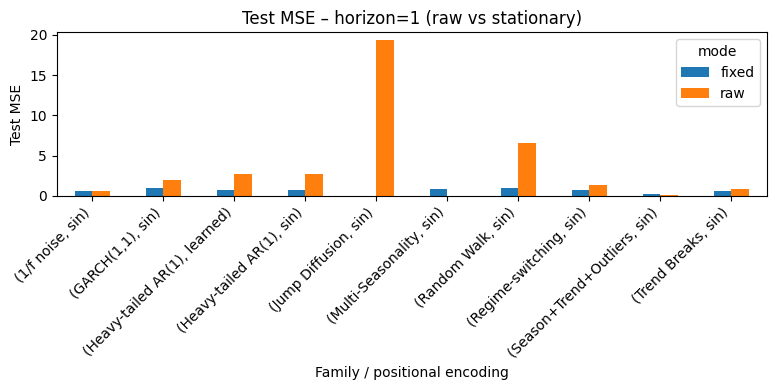

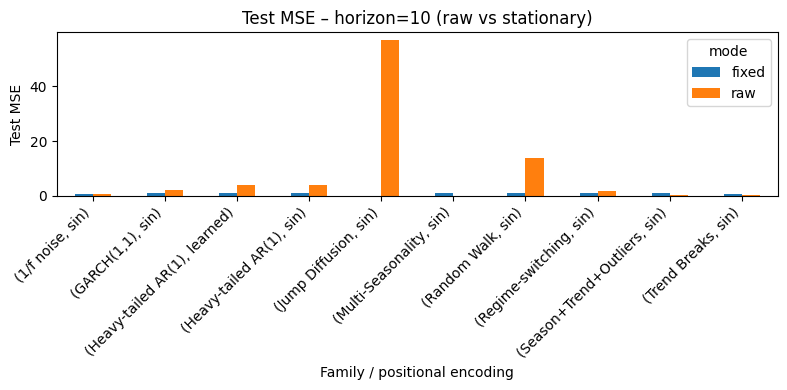

In [14]:
# 4. Visualizations
def plot_mse_raw_vs_stationary(combined_df):
    for horizon in sorted(combined_df["horizon"].unique()):
        df_h = combined_df[combined_df["horizon"] == horizon]

        plt.figure(figsize=(8, 4))
        # pivot: index=family+pos_enc, columns=mode, values=test_MSE
        df_pivot = df_h.pivot_table(
            index=["family", "pos_enc"],
            columns="mode",
            values="test_MSE",
        )

        df_pivot.plot(kind="bar", ax=plt.gca())
        plt.title(f"Test MSE – horizon={horizon} (raw vs stationary)")
        plt.ylabel("Test MSE")
        plt.xlabel("Family / positional encoding")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

plot_mse_raw_vs_stationary(combined_df)


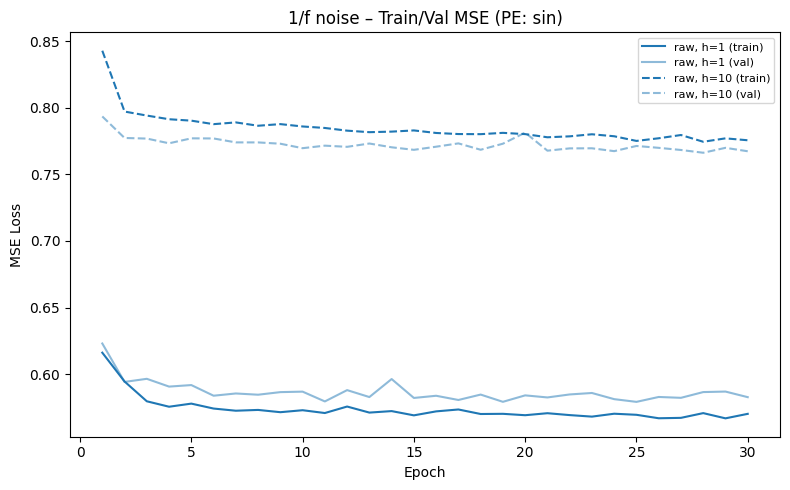

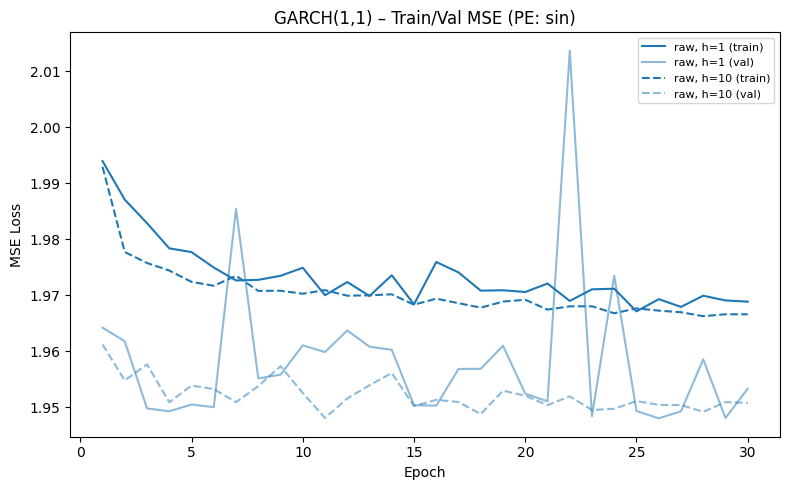

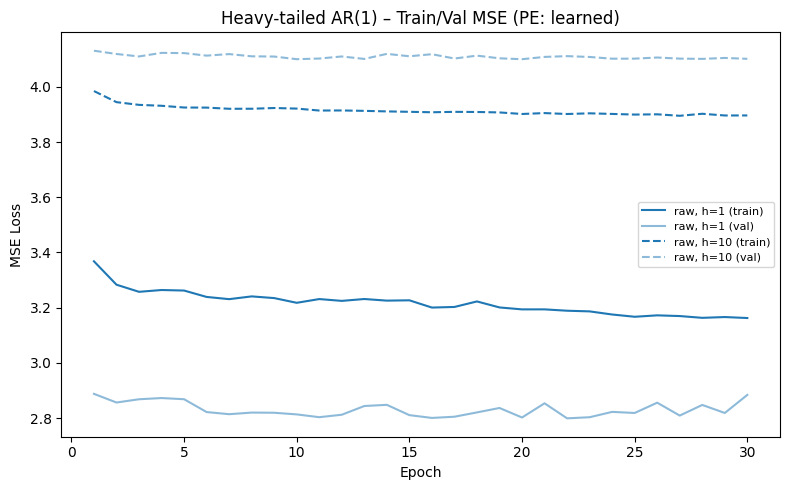

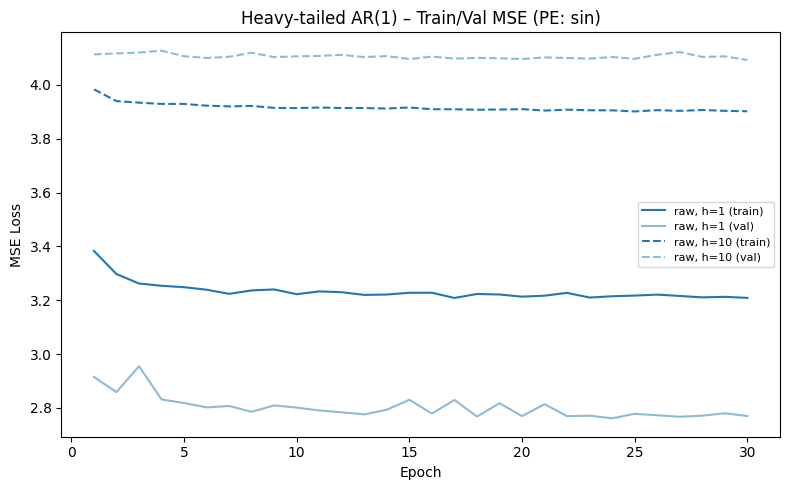

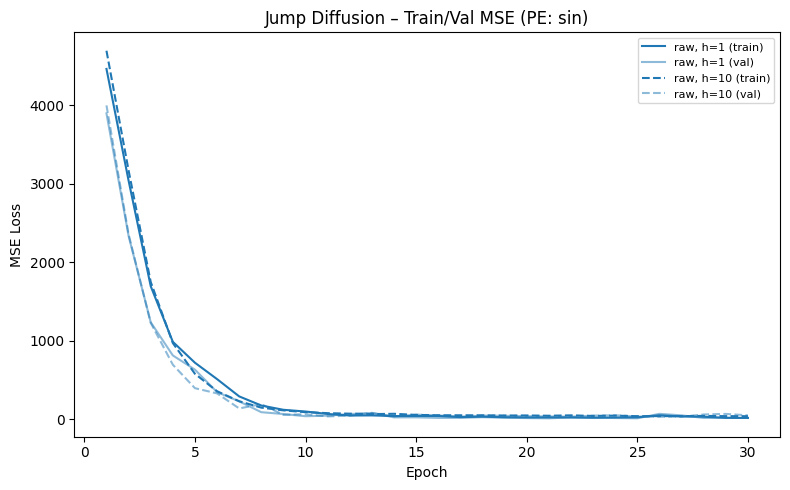

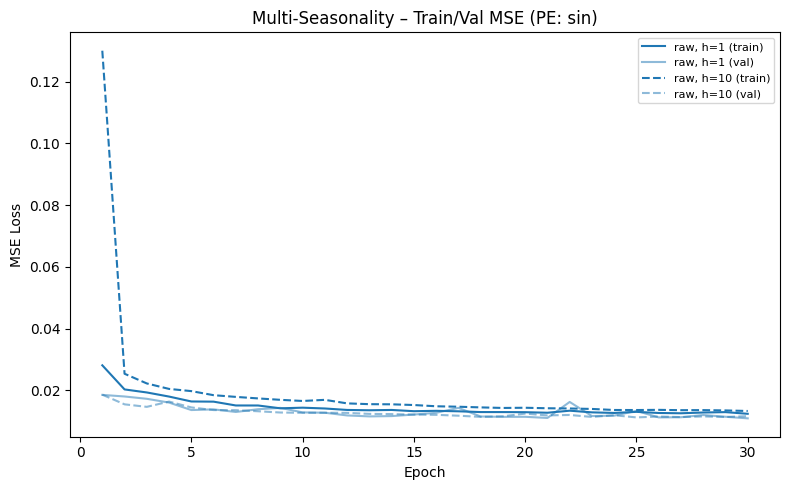

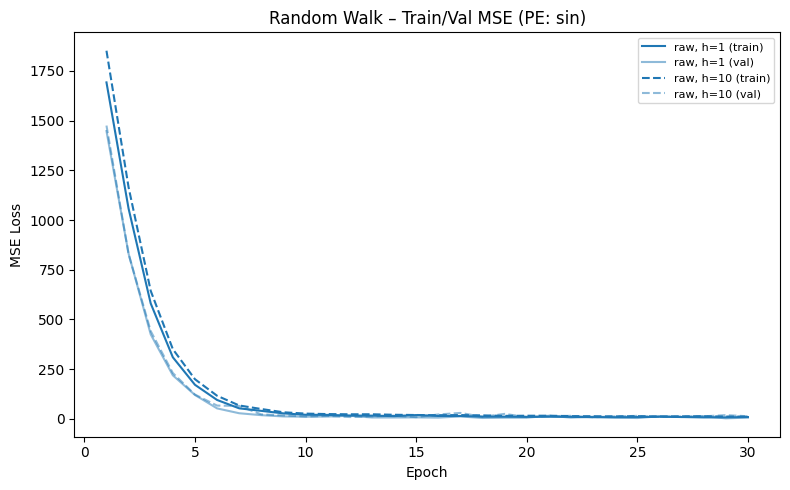

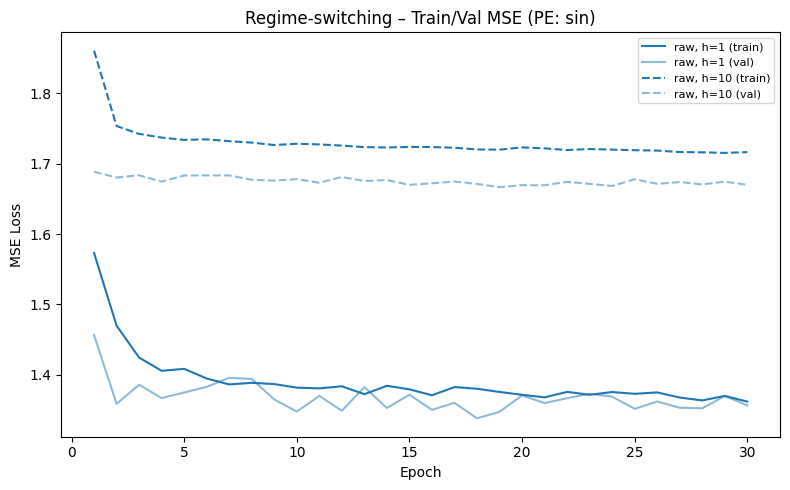

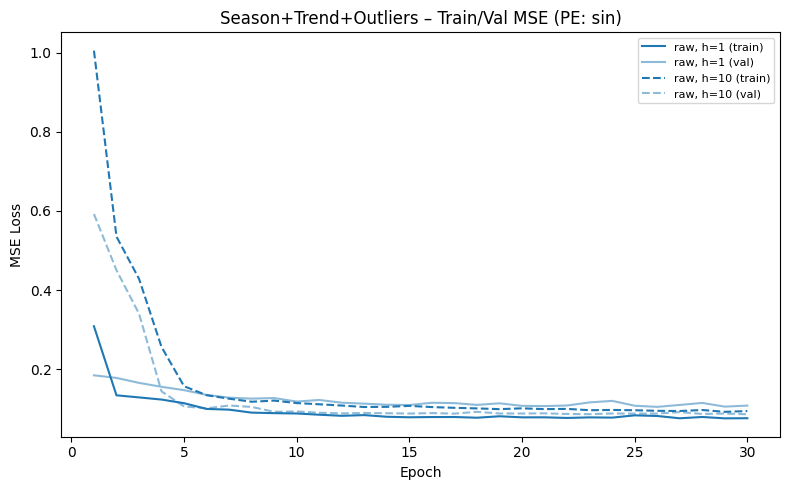

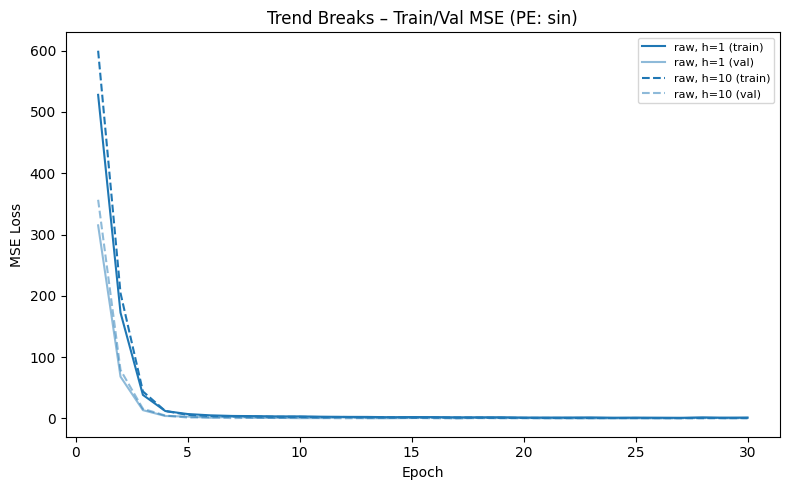

In [15]:
def plot_family_histories_comparison(histories, family, pos_enc="sin"):
    """
    Compare train/val loss across raw and stationary modes for one family and pos_enc.
    """
    plt.figure(figsize=(8, 5))
    colors = {"raw": "tab:blue", "stationary": "tab:green"}

    for mode in ["raw", "stationary"]:
        for horizon, style in zip([1, 10], ["-", "--"]):
            key = (mode, family, pos_enc, horizon)
            if key not in histories:
                continue

            hist = histories[key]
            epochs = range(1, len(hist["train_loss"]) + 1)
            color = colors[mode]
            plt.plot(epochs, hist["train_loss"], linestyle=style, color=color,
                     label=f"{mode}, h={horizon} (train)")
            plt.plot(epochs, hist["val_loss"], linestyle=style, color=color, alpha=0.5,
                     label=f"{mode}, h={horizon} (val)")

    plt.title(f"{family} – Train/Val MSE (PE: {pos_enc})")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

all_histories = {**raw_histories, **fixed_histories}
unique_families = sorted(set(fam for _, fam, *_ in all_histories))

for fam in unique_families:
    pos_encs = set(pos for mode, family, pos, *_ in all_histories if family == fam)
    for pos_enc in sorted(pos_encs):
        plot_family_histories_comparison(all_histories, fam, pos_enc)


In [16]:
def rolling_multi_step_forecast(
    model,
    series,
    input_len,
    pred_len,
    input_dim_index=0,
    device=None,
    title="Rolling multi-step forecast",
    plot=True,
):
    """
    Returns multi-step forecasts for each sliding window:
    For window ending at time t, predicts [t+1 .. t+pred_len].

    Output: DataFrame with columns:
        t, horizon, actual, pred
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure array shape (T, N)
    if torch.is_tensor(series):
        series = series.cpu().numpy()
    if series.ndim == 1:
        series = series[:, None]
    T, N = series.shape

    full_ds = SlidingWindowDataset(series, input_len=input_len, pred_len=pred_len, stride=1)
    full_loader = DataLoader(full_ds, batch_size=256, shuffle=False)

    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for X_batch, y_batch in full_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)  # (B, pred_len, N)

            preds.append(y_pred[:, :, input_dim_index].cpu().numpy())
            trues.append(y_batch[:, :, input_dim_index].cpu().numpy())

    preds = np.concatenate(preds)   # (num_windows, pred_len)
    trues = np.concatenate(trues)

    # Build dataframe with columns: t, horizon, actual, pred
    records = []
    num_windows = preds.shape[0]

    # window ending at time t = input_len + i - 1
    for i in range(num_windows):
        window_end = input_len + i - 1
        for h in range(pred_len):
            t_pred = window_end + 1 + h  # forecasting t+1 ... t+pred_len
            if t_pred < T:
                records.append({
                    "t": t_pred,
                    "horizon": h + 1,
                    "actual": trues[i, h],
                    "pred": preds[i, h],
                })

    df = pd.DataFrame(records)

    if plot:
        plt.figure(figsize=(12, 5))
        plt.plot(range(T), series[:, input_dim_index], alpha=0.4, label="actual series")

        for h in range(1, pred_len + 1):
            df_h = df[df["horizon"] == h]
            plt.plot(df_h["t"], df_h["pred"], label=f"pred (h={h})")

        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df


def make_rolling_metrics_row(
    mode,
    family,
    pos_enc,
    pred_len,
    df_forecast,
):
    """
    Compute rolling metrics (over all windows and horizons) from df_forecast.

    df_forecast columns: t, horizon, actual, pred
    """
    err = df_forecast["pred"] - df_forecast["actual"]
    roll_MSE = (err**2).mean()
    roll_MAE = err.abs().mean()

    row = {
        "mode": mode,               # "raw" or "stationary"
        "family": family,
        "pos_enc": pos_enc,
        "horizon": pred_len,        # same as pred_len (we only call this with that horizon)
        "roll_MSE": float(roll_MSE),
        "roll_MAE": float(roll_MAE),
    }

    # horizon-wise MAE
    for h in range(1, pred_len + 1):
        mask = df_forecast["horizon"] == h
        mae_h = (df_forecast.loc[mask, "pred"] - df_forecast.loc[mask, "actual"]).abs().mean()
        row[f"MAE_h{h}"] = float(mae_h)

    return row

def compute_rolling_metrics_for_mode(
    models,
    series_dict,
    mode_label,      # "raw" or "stationary"
    pred_len,        # 10 for your 10-step experiments
    device=None,
    plot=True,
):
    """
    For a given mode (raw / stationary) and horizon (e.g. 10-step),
    run rolling_multi_step_forecast for all families / pos_enc variants.

    Returns
    -------
    rolling_df : DataFrame with columns
        mode, family, pos_enc, horizon, roll_MSE, roll_MAE, MAE_h1..MAE_hK
    rolling_forecasts : dict keyed by (mode, family, pos_enc, horizon) -> df_forecast
    """
    rows = []
    rolling_forecasts = {}

    for family, cfg in series_dict.items():
        series = cfg["series"]
        input_len = cfg["input_len"]
        pos_encs = cfg["pos_encs"]

        for pos_enc in pos_encs:
            key = (mode_label, family, pos_enc, pred_len)
            if key not in models:
                continue

            model = models[key]
            title = f"{mode_label} – {family} – {pos_enc} – {pred_len}-step rolling"

            df_fore = rolling_multi_step_forecast(
                model=model,
                series=series,
                input_len=input_len,
                pred_len=pred_len,
                title=title,
                device=device,
                plot=plot,
            )

            row = make_rolling_metrics_row(
                mode=mode_label,
                family=family,
                pos_enc=pos_enc,
                pred_len=pred_len,
                df_forecast=df_fore,
            )

            rows.append(row)
            rolling_forecasts[key] = df_fore

    rolling_df = pd.DataFrame(rows)
    return rolling_df, rolling_forecasts


# -------------------------------
# Rolling Forecast Metric Computation
# -------------------------------

def compute_rolling_metrics_for_mode(
    models,
    series_dict,
    mode_label,      # "raw" or "stationary"
    pred_len,        # e.g., 10 for 10-step models
    device=None,
    plot=True,
):
    """
    For a given mode (raw / stationary) and horizon (e.g. 10-step),
    run rolling_multi_step_forecast for all families / pos_enc variants.

    Returns:
        - rolling_df: DataFrame with overall metrics
        - rolling_forecasts: dict[(mode, family, pos_enc, horizon)] -> df_forecast
    """
    rows = []
    rolling_forecasts = {}

    for family, cfg in series_dict.items():
        series = cfg["series"]
        input_len = cfg["input_len"]
        pos_encs = cfg["pos_encs"]

        for pos_enc in pos_encs:
            key = (mode_label, family, pos_enc, pred_len)
            if key not in models:
                continue

            model = models[key]
            title = f"{mode_label} – {family} – {pos_enc} – {pred_len}-step rolling"

            df_fore = rolling_multi_step_forecast(
                model=model,
                series=series,
                input_len=input_len,
                pred_len=pred_len,
                title=title,
                device=device,
                plot=plot,
            )

            row = make_rolling_metrics_row(
                mode=mode_label,
                family=family,
                pos_enc=pos_enc,
                pred_len=pred_len,
                df_forecast=df_fore,
            )

            rows.append(row)
            rolling_forecasts[key] = df_fore

    rolling_df = pd.DataFrame(rows)
    return rolling_df, rolling_forecasts


In [17]:
# Compute rolling forecasts for raw and stationary models
rolling_raw_df, rolling_raw_forecasts = compute_rolling_metrics_for_mode(
    models=raw_models,
    series_dict=raw_dict,
    mode_label="raw",
    pred_len=10,        # or whatever pred_len you used
    device=None,
    plot=False,         # turn off plotting if looping
)

rolling_stat_df, rolling_stat_forecasts = compute_rolling_metrics_for_mode(
    models=fixed_models,
    series_dict=fixed_dict,
    mode_label="fixed",
    pred_len=10,
    device=None,
    plot=False,
)


In [18]:
# -------------------------------
# Plotting: Raw vs. Stationary Rolling Forecasts
# -------------------------------

def plot_raw_vs_stationary_rolling(
    family,
    pos_enc="sin",
    horizon=10,
    max_horizons_to_show=3,
    raw_series_dict=raw_dict,
    stationary_series_dict=stationary_dict,
    rolling_raw_forecasts=rolling_raw_forecasts,
    rolling_stat_forecasts=rolling_stat_forecasts,
):
    """
    Side-by-side forecast comparison for one family.
    """
    key_raw = ("raw", family, pos_enc, horizon)
    key_stat = ("fixed", family, pos_enc, horizon)

    if key_raw not in rolling_raw_forecasts or key_stat not in rolling_stat_forecasts:
        print(f"Skipping {family} ({pos_enc}) – missing forecast.")
        return

    df_raw = rolling_raw_forecasts[key_raw]
    df_stat = rolling_stat_forecasts[key_stat]

    series_raw = raw_series_dict[family]["series"]
    series_stat = stationary_series_dict[family]["series"]

    if series_raw.ndim == 2:
        series_raw = series_raw[:, 0]
    if series_stat.ndim == 2:
        series_stat = series_stat[:, 0]

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    for ax, df, series, label in zip(axes, [df_raw, df_stat], [series_raw, series_stat], ["RAW", "STATIONARY"]):
        ax.plot(np.arange(len(series)), series, alpha=0.3, label="input series")
        df_h1 = df[df["horizon"] == 1]
        ax.plot(df_h1["t"], df_h1["actual"], alpha=0.6, label="actual targets")

        for h in range(1, min(max_horizons_to_show, horizon) + 1):
            df_h = df[df["horizon"] == h]
            ax.plot(df_h["t"], df_h["pred"], label=f"pred (h={h})")

        ax.set_title(f"{label} – {family} – PE: {pos_enc}")
        ax.set_xlabel("Time")
        ax.legend()

    axes[0].set_ylabel("Value")
    plt.suptitle(f"{family} – {pos_enc} – {horizon}-step Rolling Forecast", y=1.02)
    plt.tight_layout()
    plt.show()


Plotting 1/f noise...


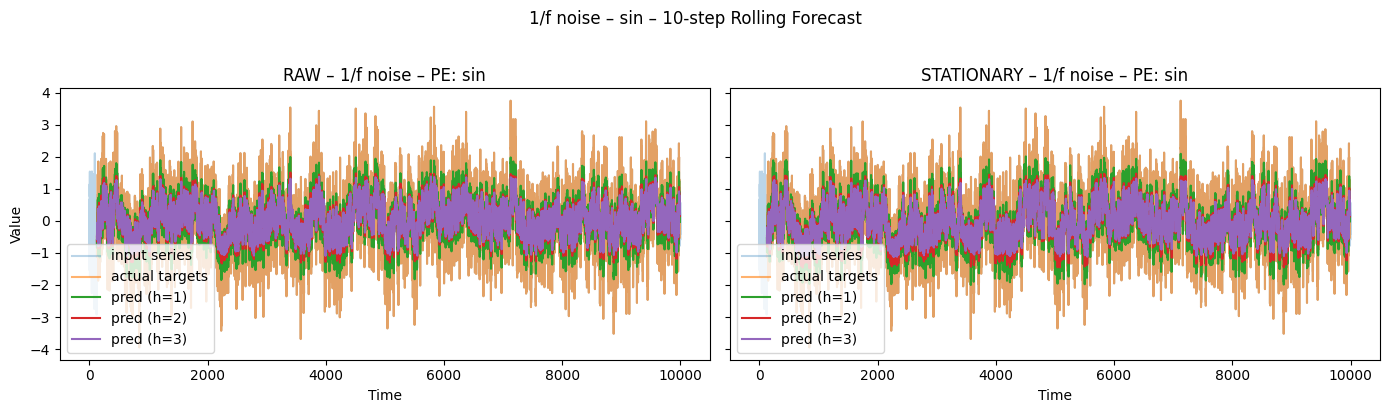

Plotting GARCH(1,1)...


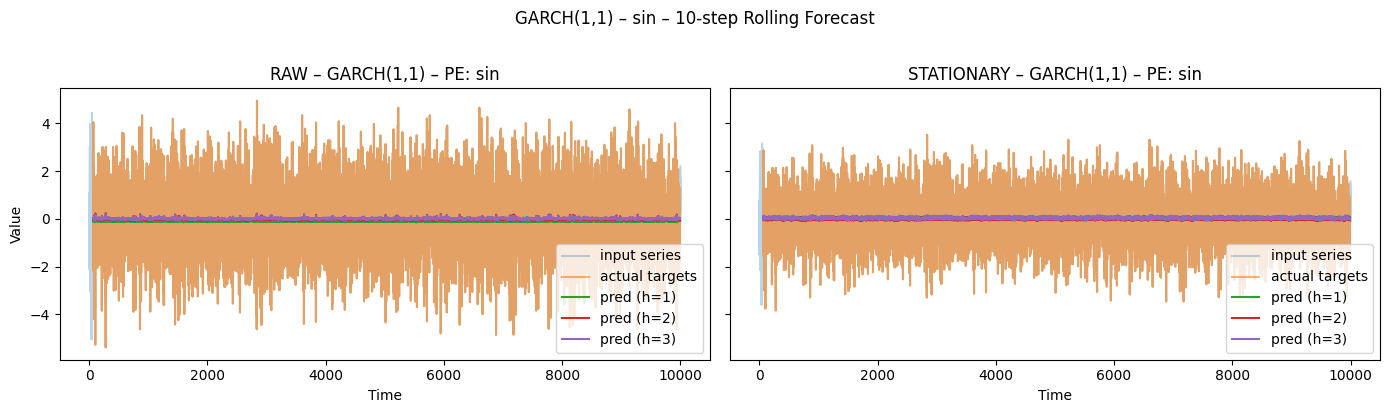

Plotting Heavy-tailed AR(1)...


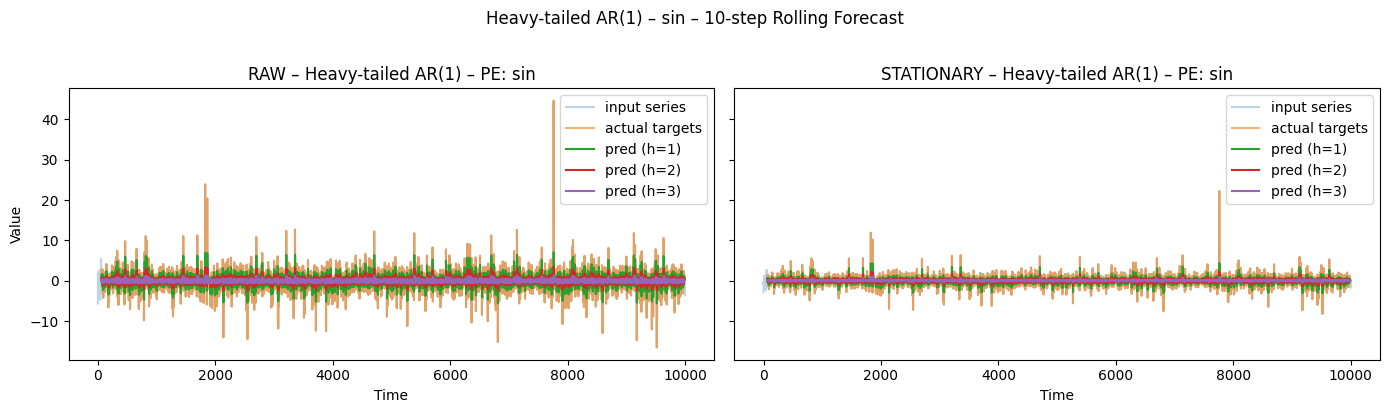

Plotting Jump Diffusion...


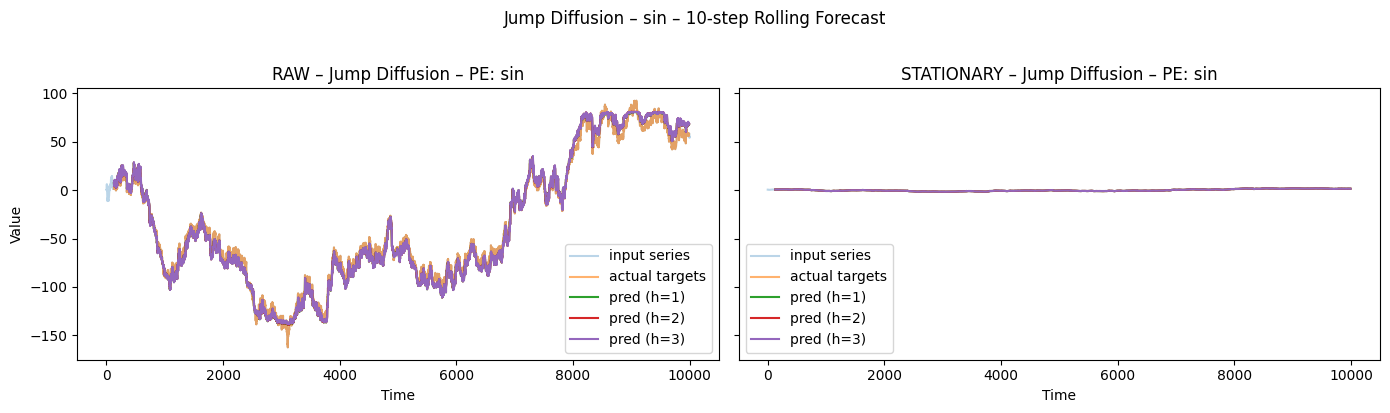

Plotting Multi-Seasonality...


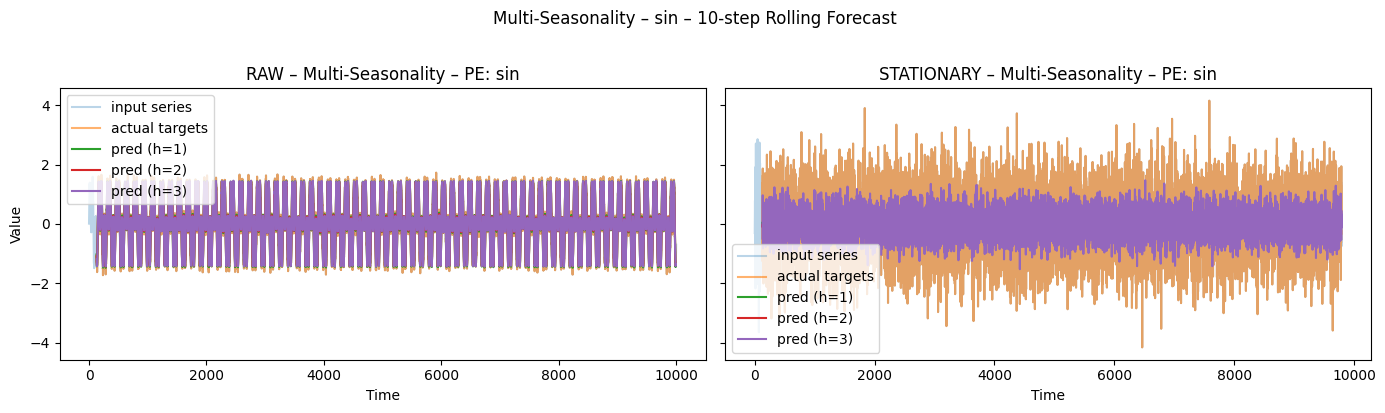

Plotting Random Walk...


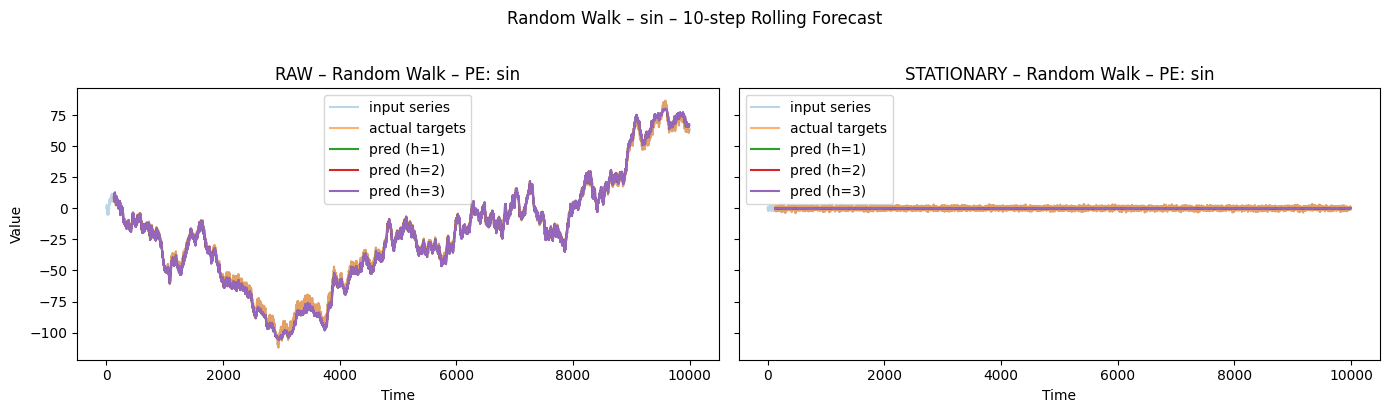

Plotting Regime-switching...


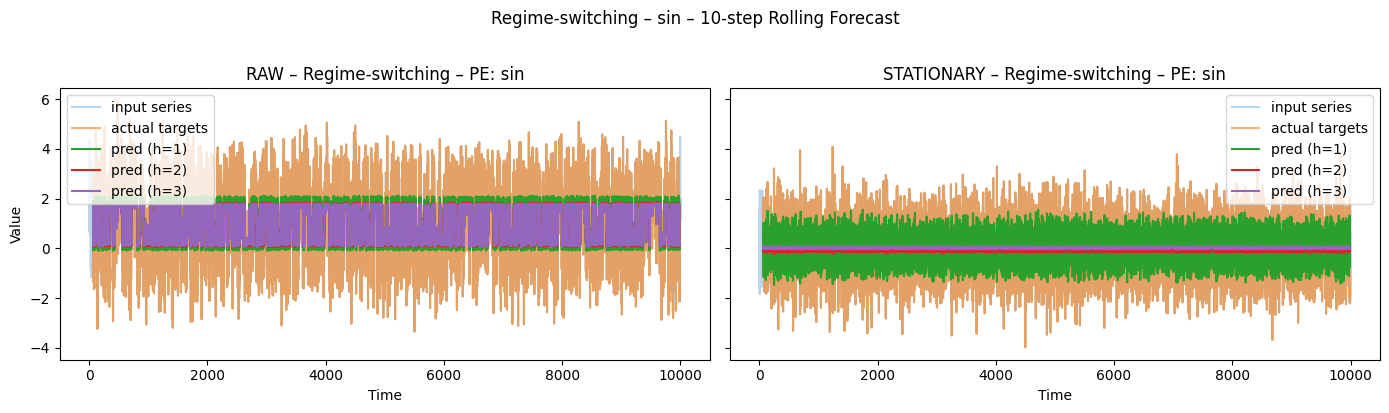

Plotting Season+Trend+Outliers...


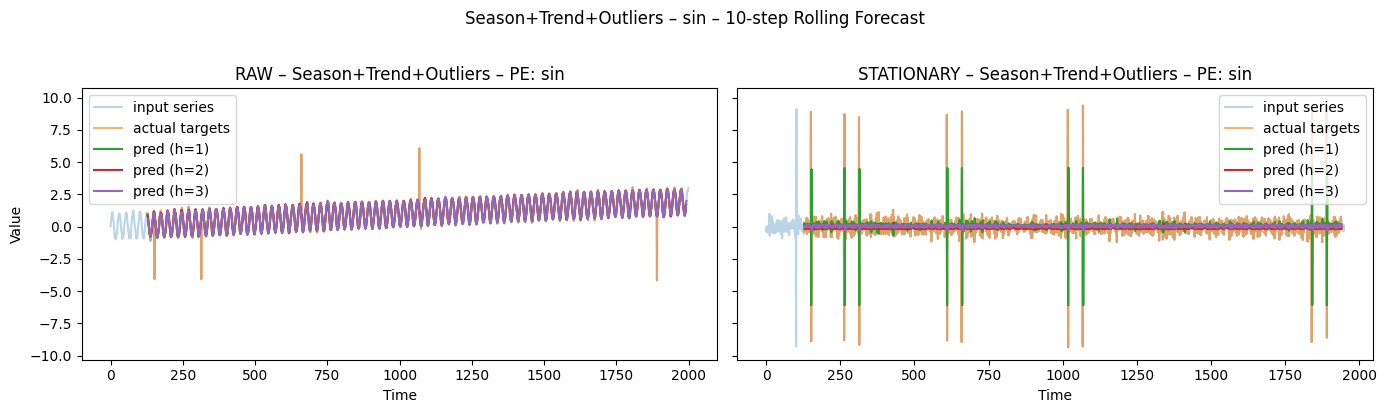

Plotting Trend Breaks...


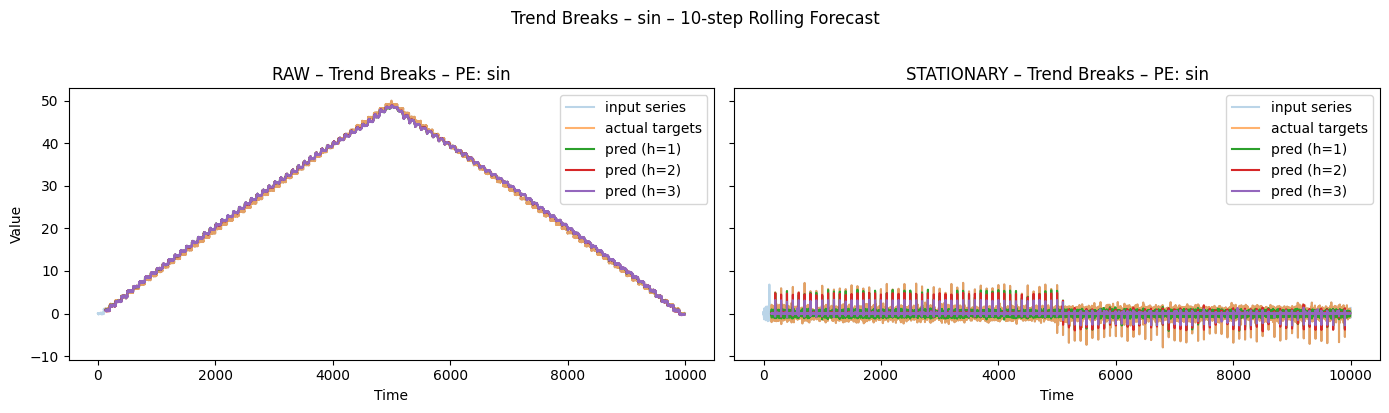

In [19]:
# Extract all unique families from rolling_raw_forecasts that match the conditions
families_to_plot = sorted({
    key[1]
    for key in rolling_raw_forecasts.keys()
    if key[2] == "sin" and key[3] == 10
})

for family in families_to_plot:
    print(f"Plotting {family}...")
    plot_raw_vs_stationary_rolling(
        family=family,
        pos_enc="sin",
        horizon=10,
        raw_series_dict=raw_dict,
        stationary_series_dict=fixed_dict,
        rolling_raw_forecasts=rolling_raw_forecasts,
        rolling_stat_forecasts=rolling_stat_forecasts,
    )


In [20]:
def get_attention_weights(model, input_tensor):
    attention_weights = []

    def hook_fn(module, input, output):
        attn_output, attn_weights = output
        attention_weights.append(attn_weights.detach().cpu())

    # Register hook on the MultiheadAttention layer(s)
    handles = []
    for layer in model.encoder.layers:
        handle = layer.self_attn.register_forward_hook(hook_fn)
        handles.append(handle)

    with torch.no_grad():
        model.eval()
        model(input_tensor)

    # Clean up hooks
    for handle in handles:
        handle.remove()

    return attention_weights

def visualize_attention_for_all(models_dict, series_dict, mode="raw", pos_enc="sin", horizon=10):
    for key, model in models_dict.items():
        m, family, pe, h = key
        if m != mode or pe != pos_enc or h != horizon:
            continue

        print(f"Visualizing: {m} | {family} | {pe} | horizon={h}")

        # Prepare input
        series = series_dict[family]["series"]
        input_len = series_dict[family]["input_len"]

        if isinstance(series, np.ndarray):
            x = series[:input_len].reshape(1, input_len, 1)  # (B, T, C)
        else:
            x = series.values[:input_len].reshape(1, input_len, 1)

        x_tensor = torch.tensor(x, dtype=torch.float32)

        # Move to model device
        device = next(model.parameters()).device
        x_tensor = x_tensor.to(device)

        # Get attention weights
        attn_weights = get_attention_weights(model, x_tensor)

        # Plot attention weights from first layer
        if attn_weights:
            attn = attn_weights[0][0]  # shape: (n_heads, T, T)
            n_heads = attn.shape[0]

            fig, axes = plt.subplots(1, n_heads, figsize=(3 * n_heads, 3))
            if n_heads == 1:
                axes = [axes]

            for i, ax in enumerate(axes):
                im = ax.imshow(attn[i], cmap="viridis")
                ax.set_title(f"Head {i}")
                ax.set_xlabel("Input Timestep")
                ax.set_ylabel("Query Timestep")
                fig.colorbar(im, ax=ax)

            plt.suptitle(f"Attention Map – {m} | {family} | PE: {pe}", y=1.05)
            plt.tight_layout()
            plt.show()


Visualizing: raw | Heavy-tailed AR(1) | sin | horizon=1


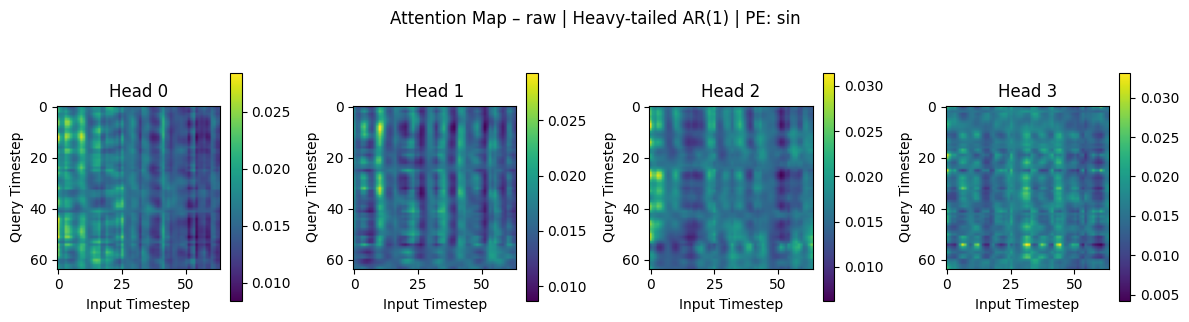

Visualizing: raw | GARCH(1,1) | sin | horizon=1


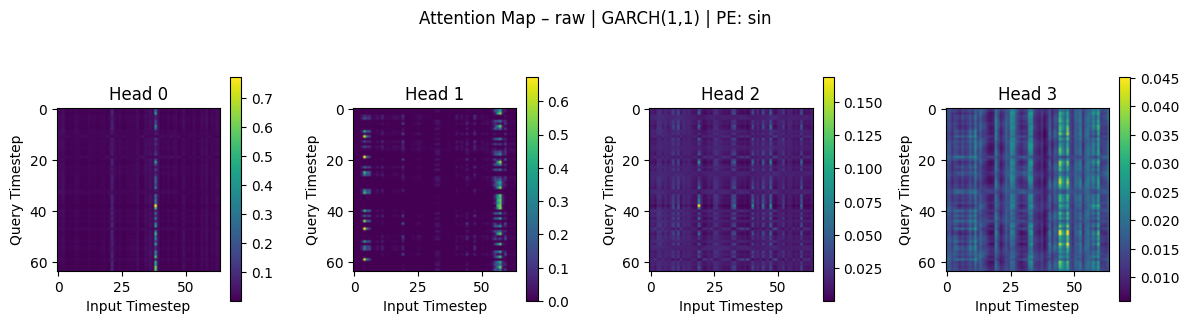

Visualizing: raw | Regime-switching | sin | horizon=1


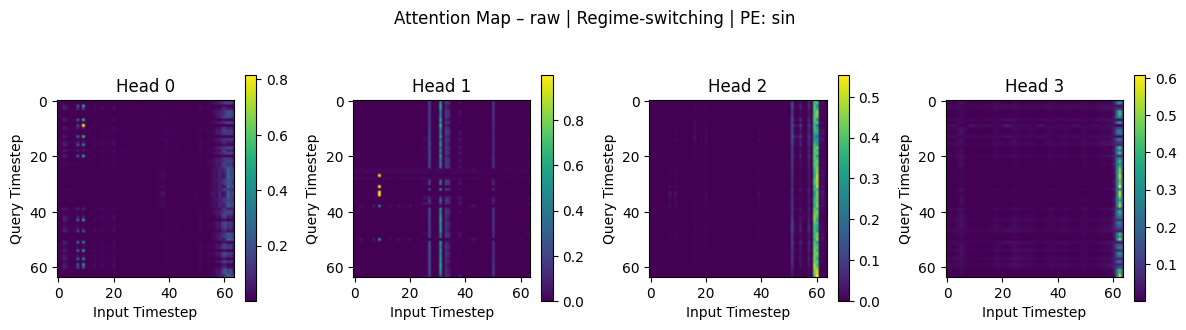

Visualizing: raw | 1/f noise | sin | horizon=1


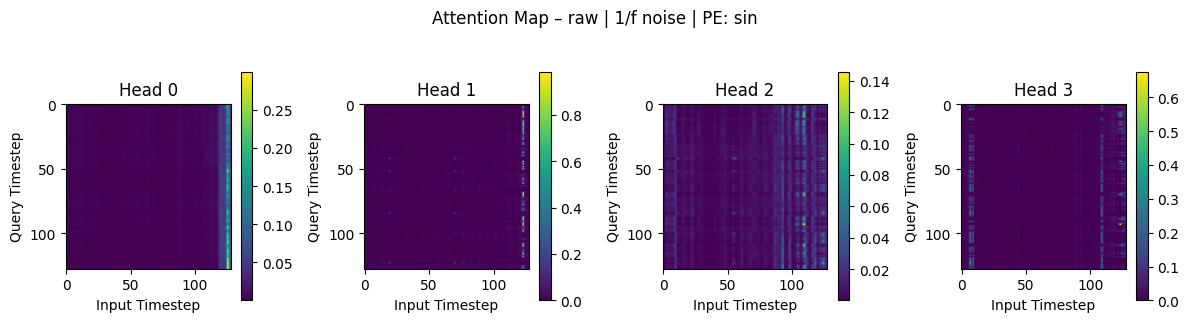

Visualizing: raw | Season+Trend+Outliers | sin | horizon=1


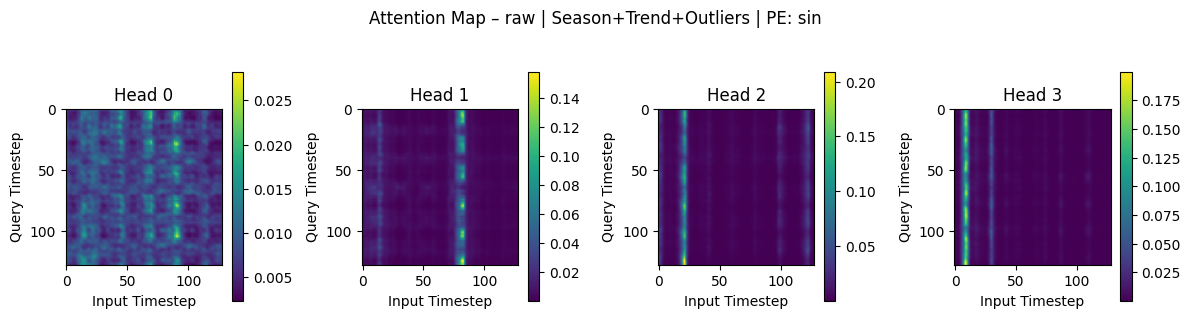

Visualizing: raw | Random Walk | sin | horizon=1


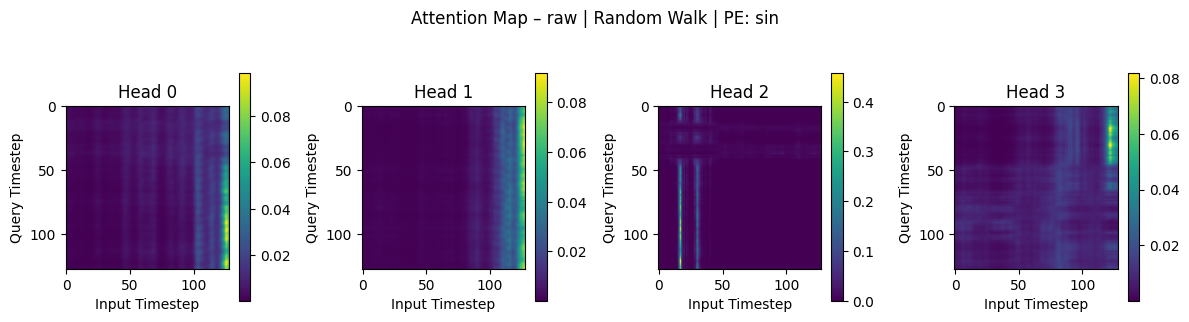

Visualizing: raw | Jump Diffusion | sin | horizon=1


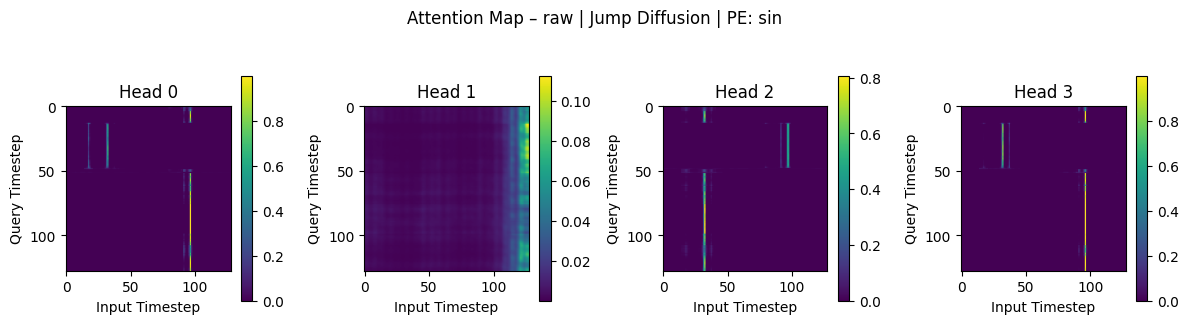

Visualizing: raw | Multi-Seasonality | sin | horizon=1


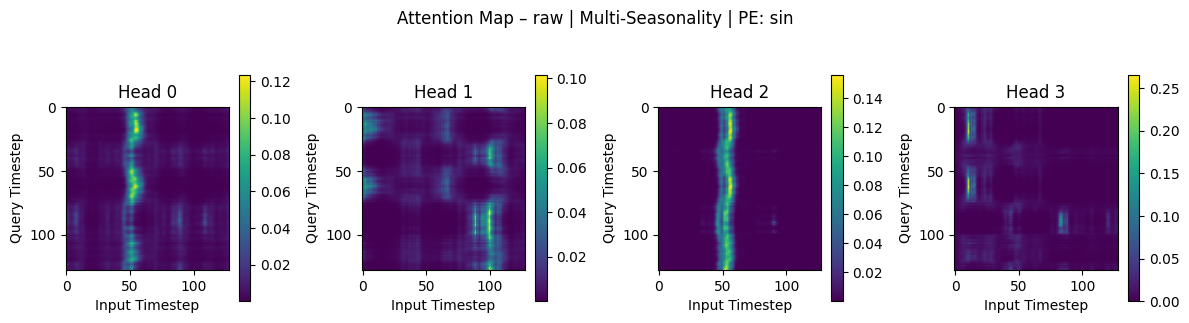

Visualizing: raw | Trend Breaks | sin | horizon=1


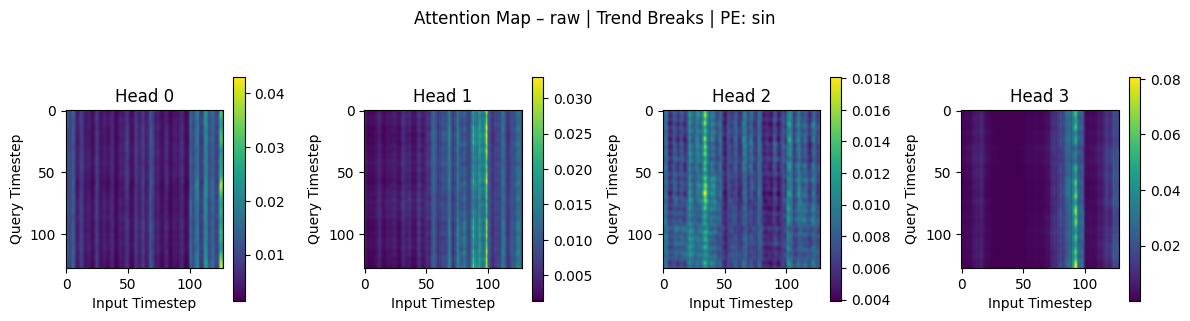

In [21]:
visualize_attention_for_all(
    models_dict=raw_models,        # not fixed_models
    series_dict=raw_dict,          # not fixed_dict
    mode="raw",                    # this matches the keys in raw_models
    pos_enc="sin",
    horizon=1
)

Visualizing: fixed | Heavy-tailed AR(1) | sin | horizon=1


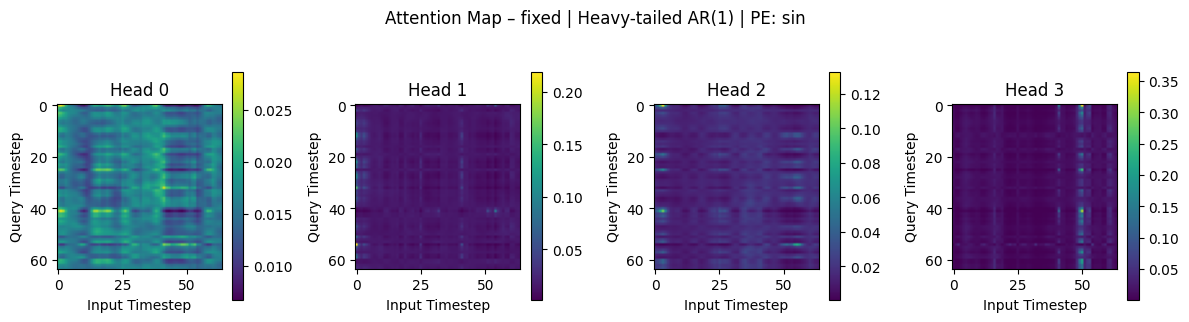

Visualizing: fixed | GARCH(1,1) | sin | horizon=1


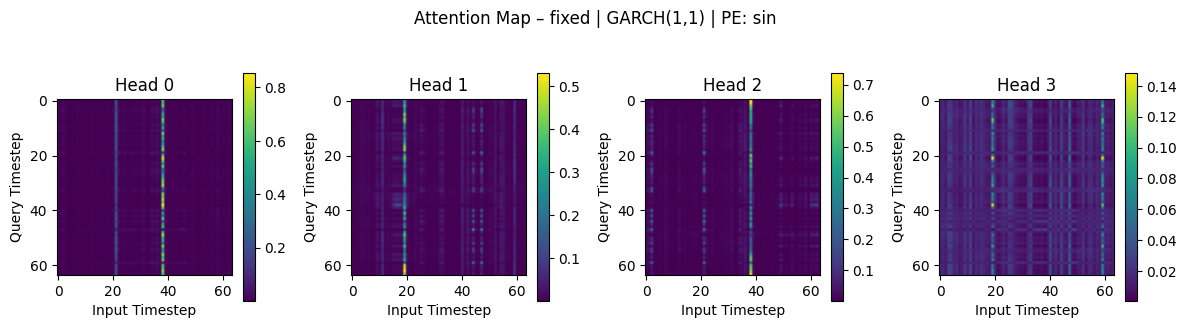

Visualizing: fixed | Regime-switching | sin | horizon=1


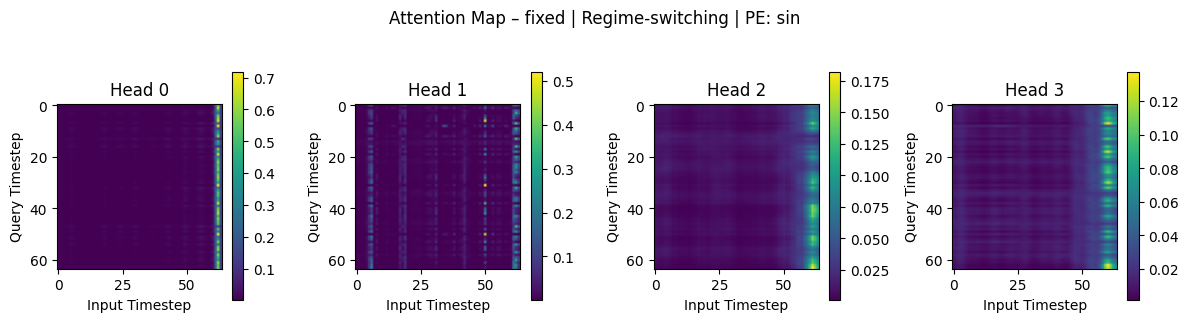

Visualizing: fixed | 1/f noise | sin | horizon=1


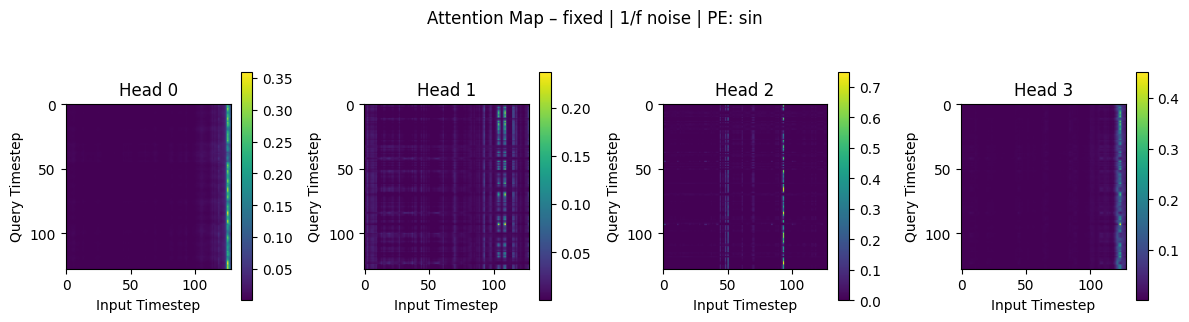

Visualizing: fixed | Season+Trend+Outliers | sin | horizon=1


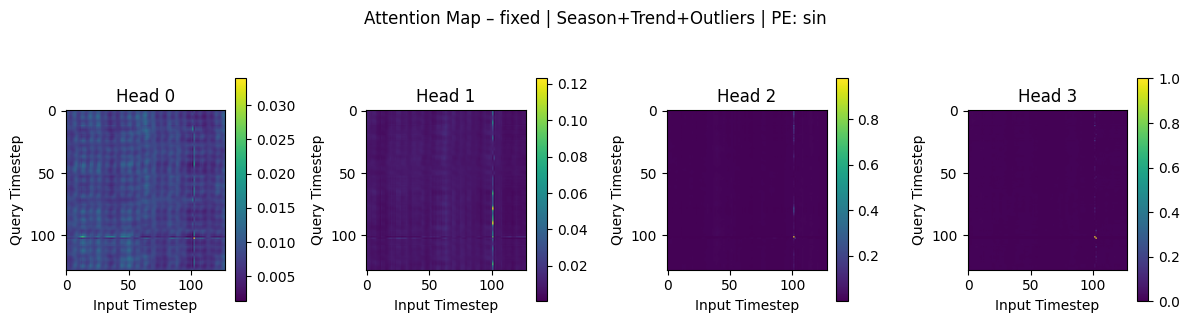

Visualizing: fixed | Random Walk | sin | horizon=1


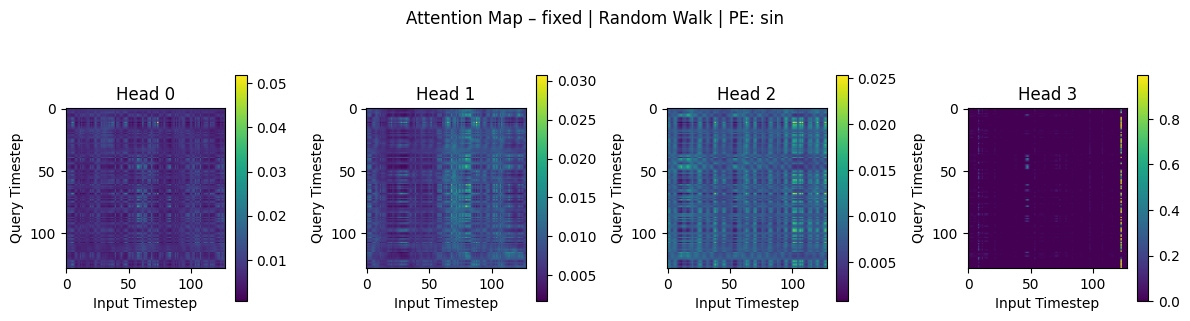

Visualizing: fixed | Jump Diffusion | sin | horizon=1


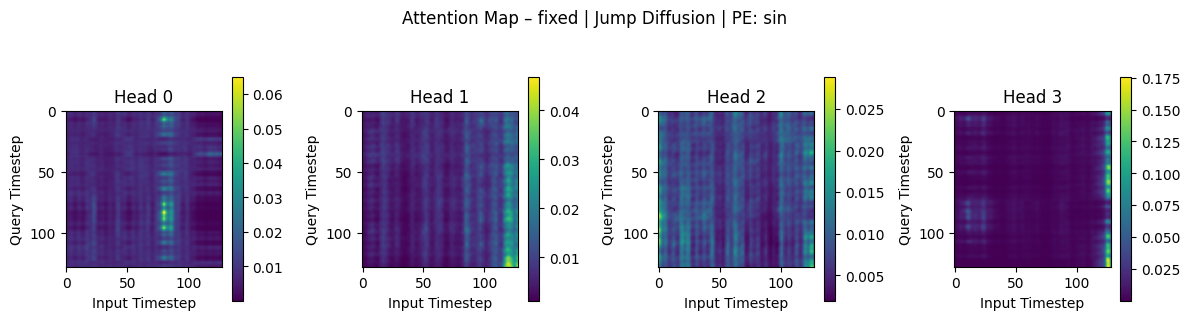

Visualizing: fixed | Multi-Seasonality | sin | horizon=1


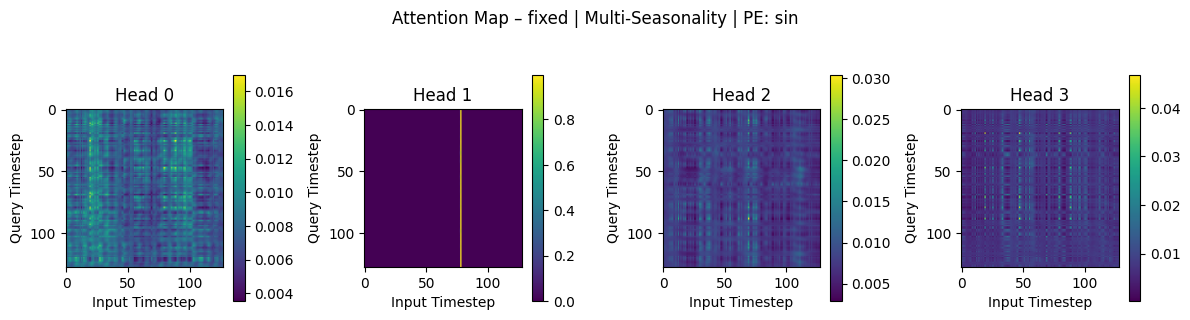

Visualizing: fixed | Trend Breaks | sin | horizon=1


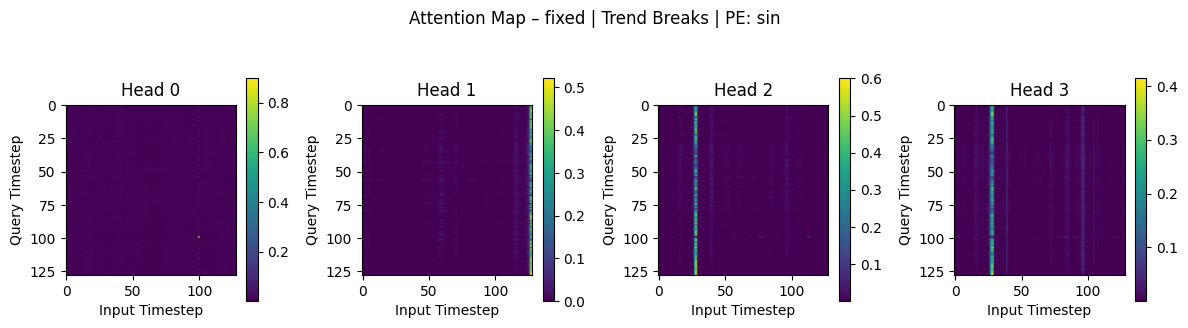

In [22]:
visualize_attention_for_all(
    models_dict=fixed_models,
    series_dict=fixed_dict,
    mode="fixed",
    pos_enc="sin",    # or "learned"
    horizon=1
)

Visualizing: raw | Heavy-tailed AR(1) | sin | horizon=10


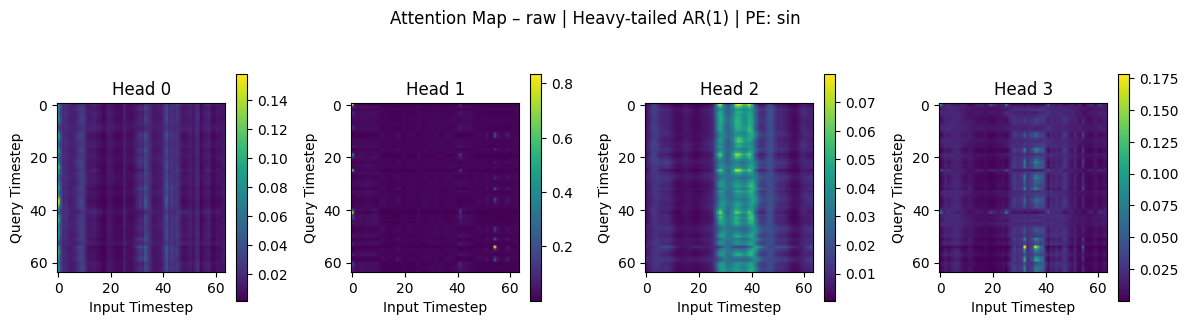

Visualizing: raw | GARCH(1,1) | sin | horizon=10


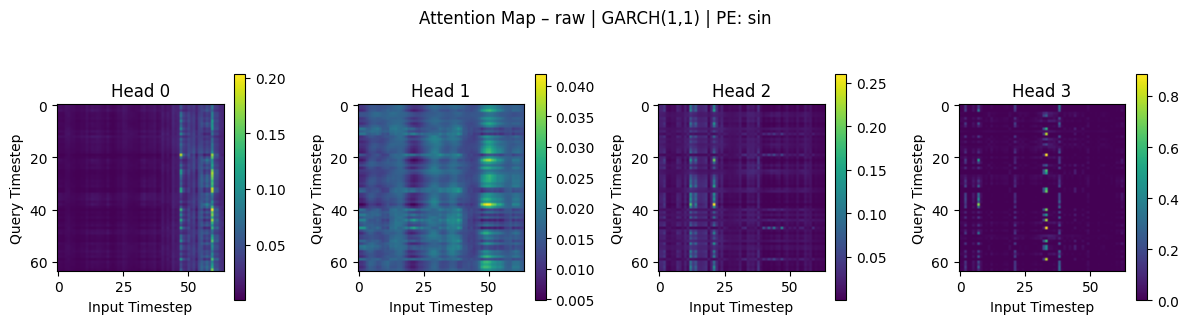

Visualizing: raw | Regime-switching | sin | horizon=10


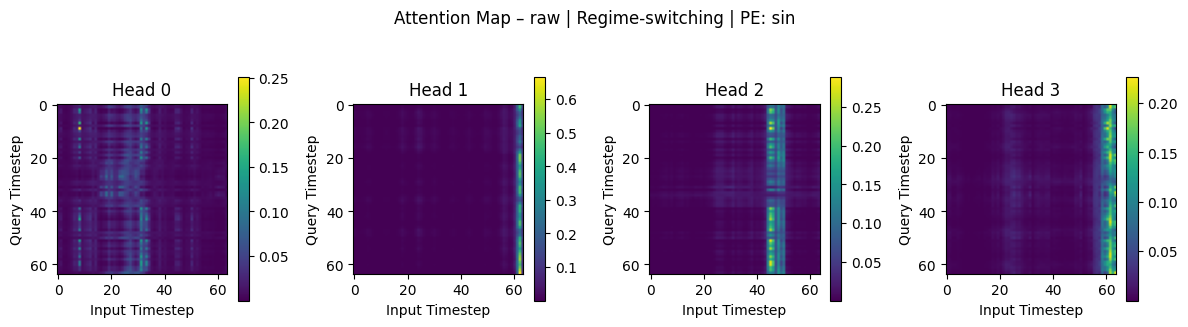

Visualizing: raw | 1/f noise | sin | horizon=10


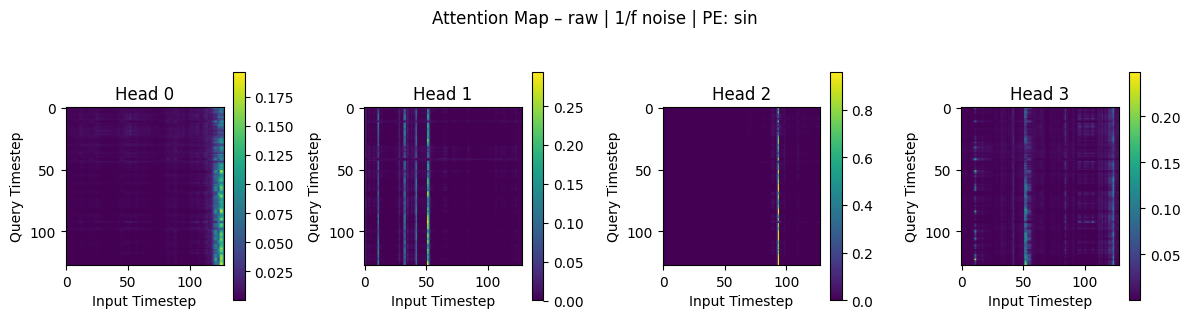

Visualizing: raw | Season+Trend+Outliers | sin | horizon=10


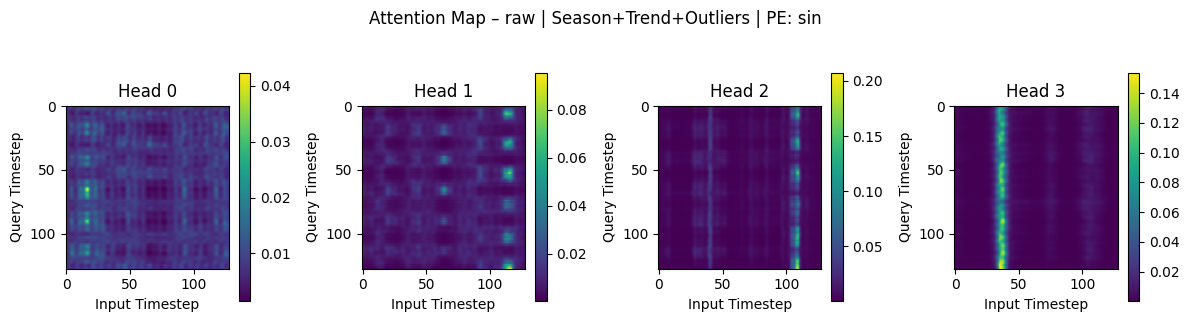

Visualizing: raw | Random Walk | sin | horizon=10


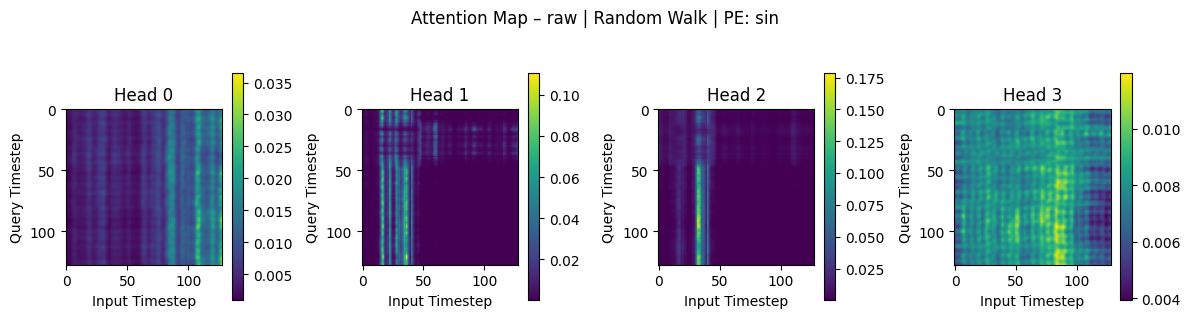

Visualizing: raw | Jump Diffusion | sin | horizon=10


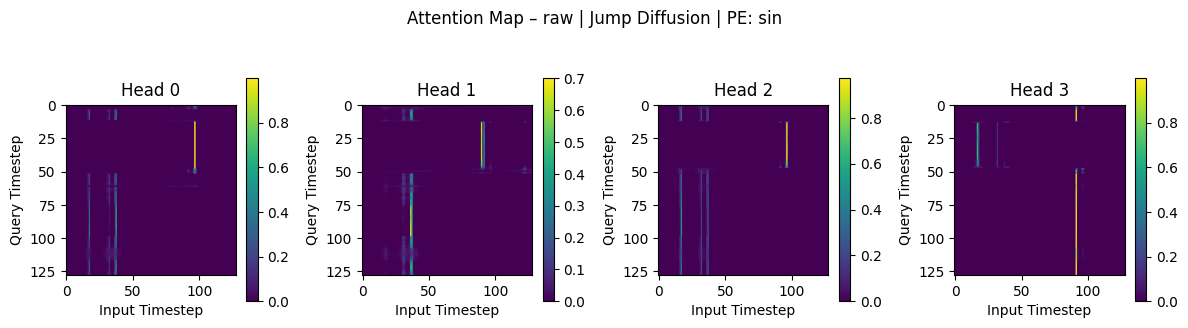

Visualizing: raw | Multi-Seasonality | sin | horizon=10


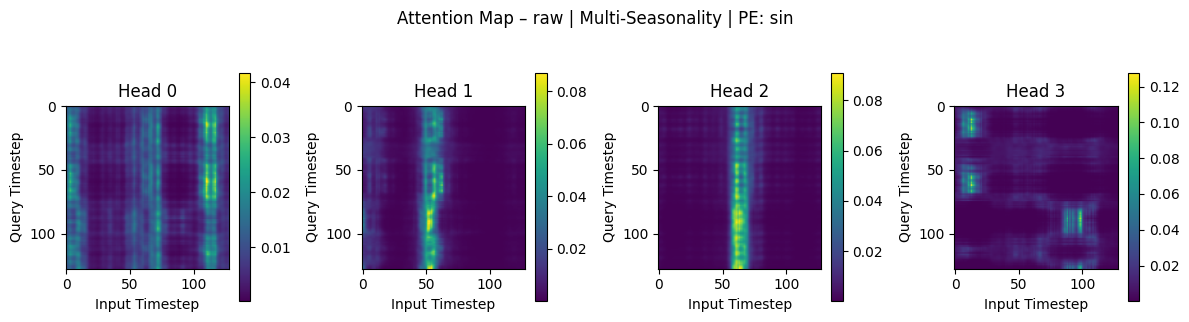

Visualizing: raw | Trend Breaks | sin | horizon=10


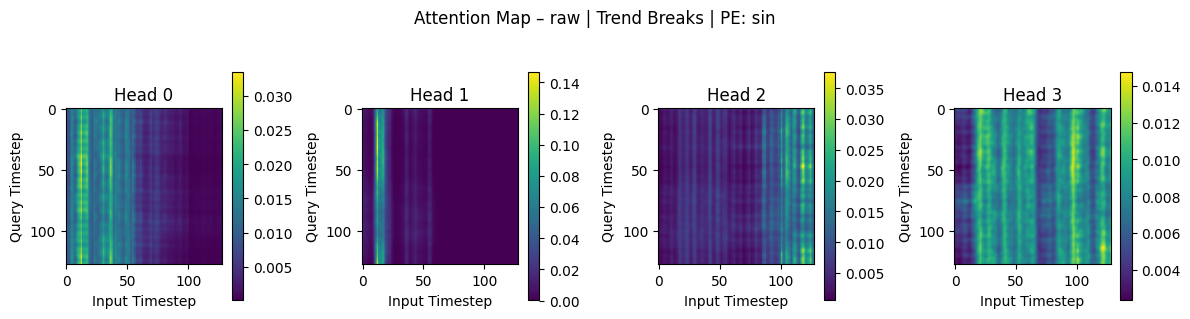

In [23]:
visualize_attention_for_all(
    models_dict=raw_models,        # not fixed_models
    series_dict=raw_dict,          # not fixed_dict
    mode="raw",                    # this matches the keys in raw_models
    pos_enc="sin",
    horizon=10
)


Visualizing: fixed | Heavy-tailed AR(1) | sin | horizon=10


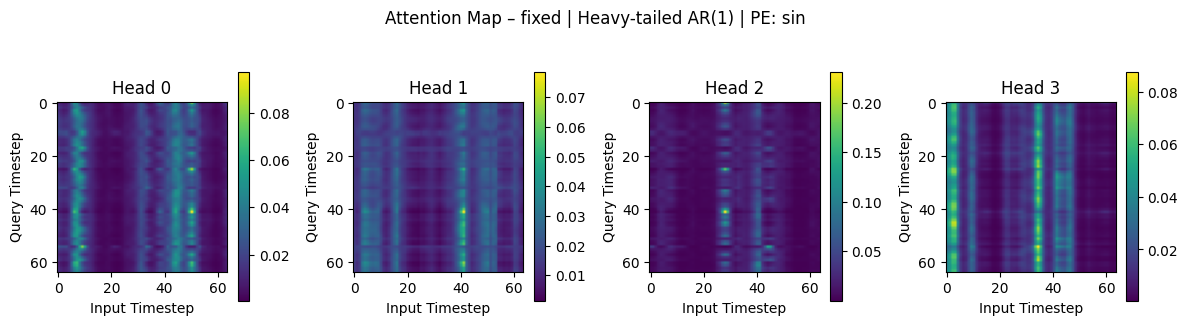

Visualizing: fixed | GARCH(1,1) | sin | horizon=10


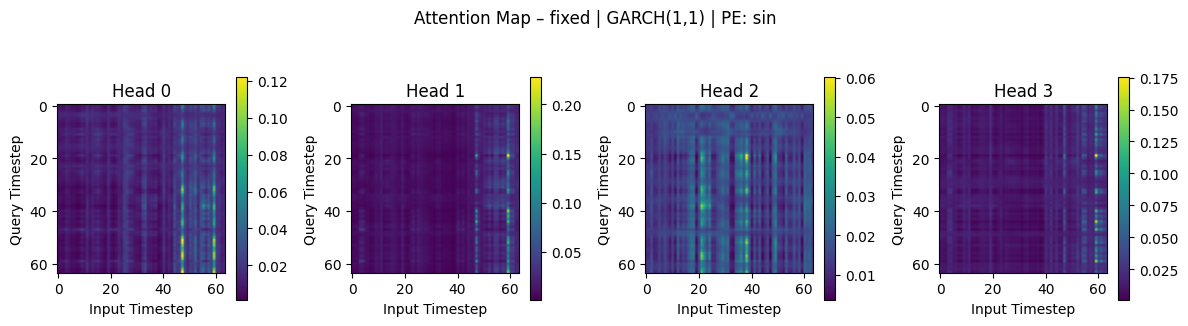

Visualizing: fixed | Regime-switching | sin | horizon=10


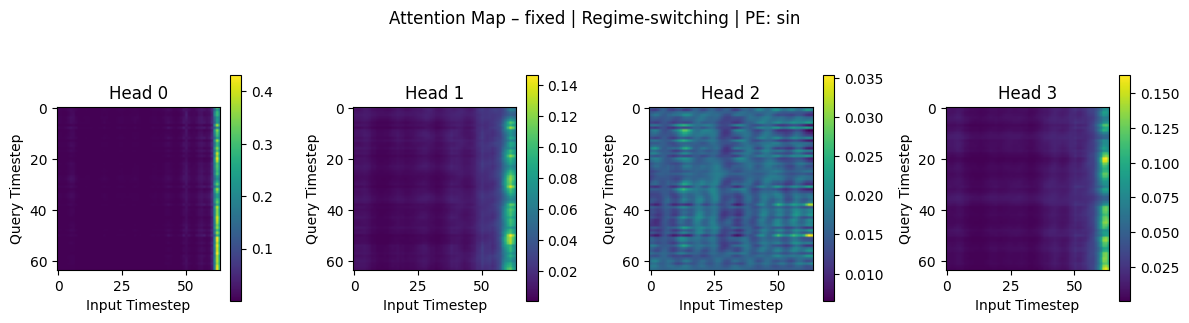

Visualizing: fixed | 1/f noise | sin | horizon=10


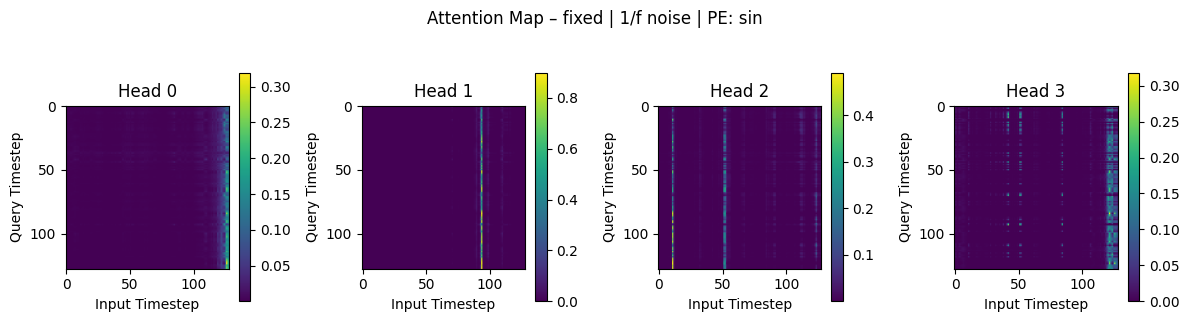

Visualizing: fixed | Season+Trend+Outliers | sin | horizon=10


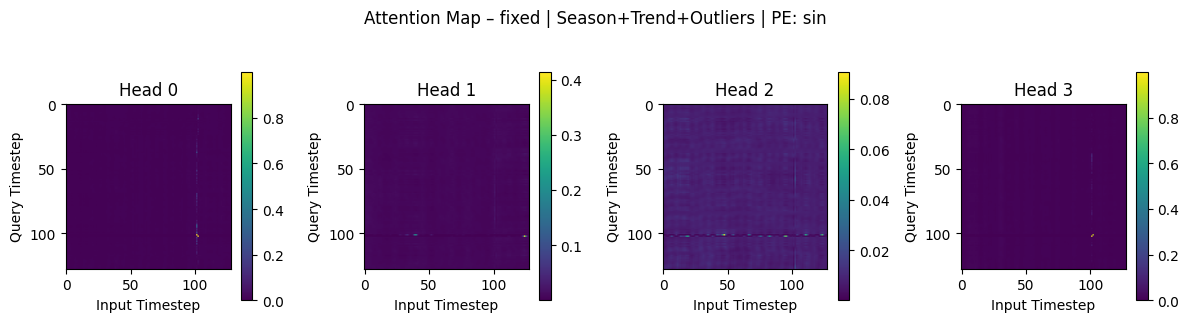

Visualizing: fixed | Random Walk | sin | horizon=10


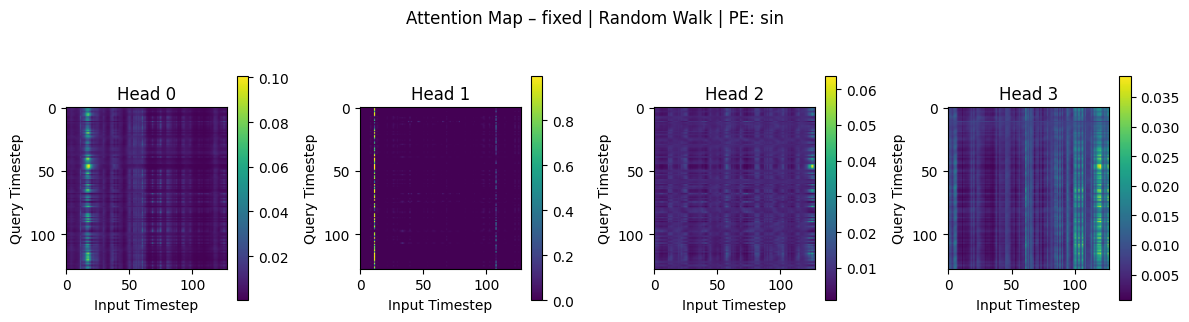

Visualizing: fixed | Jump Diffusion | sin | horizon=10


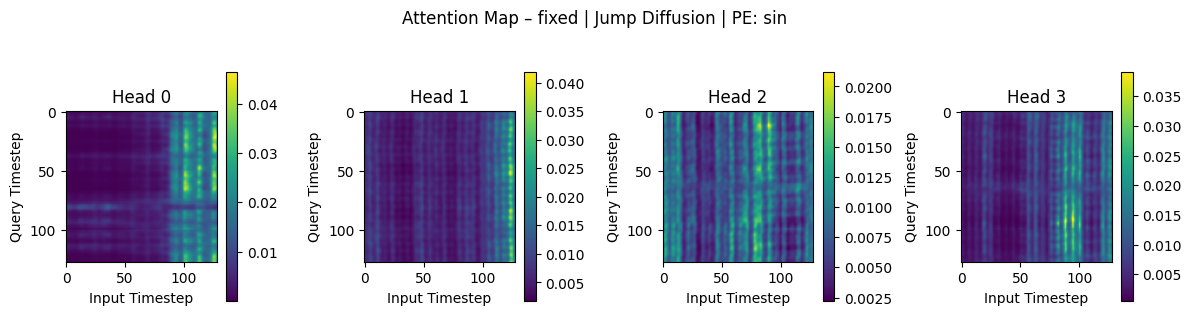

Visualizing: fixed | Multi-Seasonality | sin | horizon=10


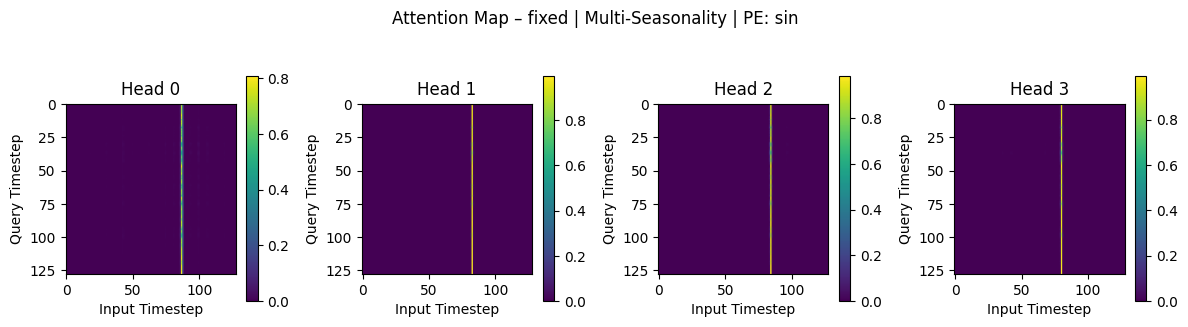

Visualizing: fixed | Trend Breaks | sin | horizon=10


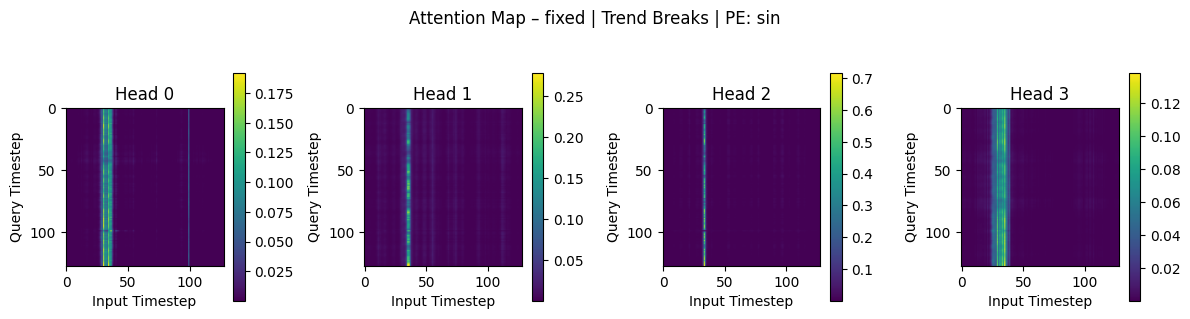

In [24]:
visualize_attention_for_all(
    models_dict=fixed_models,
    series_dict=fixed_dict,
    mode="fixed",
    pos_enc="sin",    # or "learned"
    horizon=10
)